In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import datetime

## Importo Ti de las ZT base y con imputaciones (base y ann)

In [3]:

sim_base3=pd.read_csv('simulation_data/base_EPW_infilt_thermal_load.csv',index_col=0,parse_dates=True)#'simulation_data/base_EPW.csv'
sim_ann_imp3=pd.read_csv('simulation_data/imputed_EPW_infilt_thermal_load.csv',index_col=0,parse_dates=True)#imputed_EPW_wind_exposed.csv

to=pd.read_csv('../02_simulation/edificio_este/run/002_ExportVariabletoCSV 1/report_SiteOutdoorAirDrybulbTemperature_ZoneTimestep.csv',index_col=0,parse_dates=True,skiprows=1,names=['tiempo','to'])
# 'simulation_data/cnn_mae.csv'

In [4]:
params={'text.latex.preamble':'\\usepackage{lmodern,amsmath}',
       'text.usetex':True,
       'font.size':11,
       'font.family':'lmodern'}
h_fmt=mdates.DateFormatter('%m-%d-%H')
hours=mdates.HourLocator(byhour=[0,6,12,18])
plt.rcParams.update(params)

# Thermal zone selection

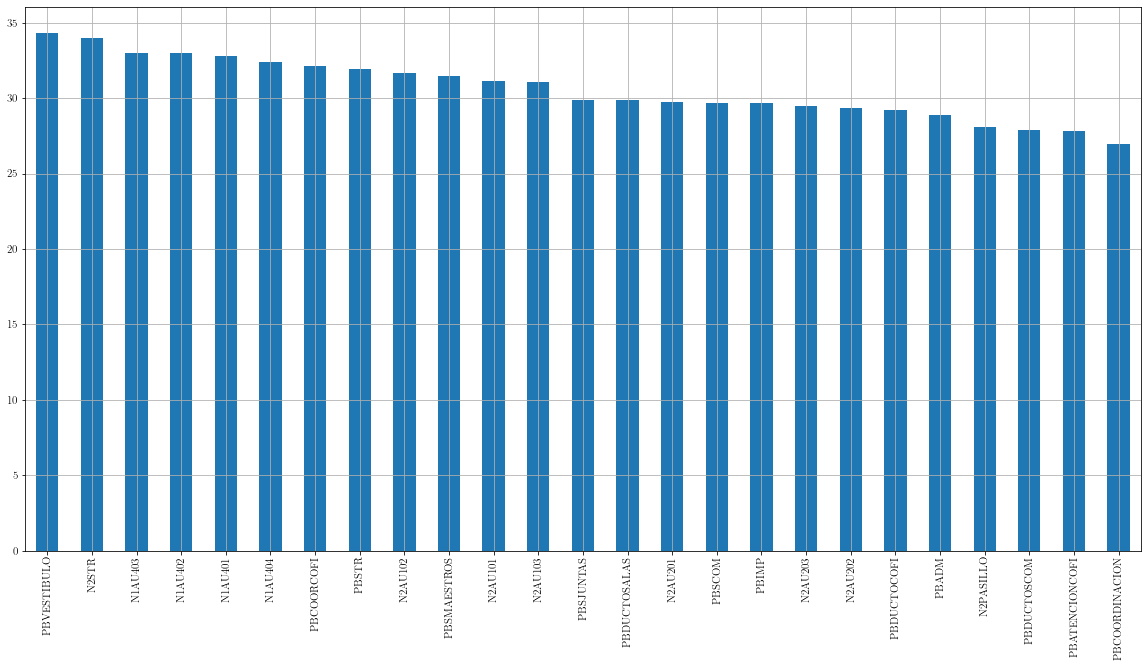

In [5]:
df=sim_base3.resample('D').max().resample('Y').mean()
df=df.T.sort_values(by=['2018-12-31'],ascending=False)
# df=df.sort_values()
df['2018-12-31'].plot.bar(figsize=(20,10))
plt.grid()

In [6]:
tzs=['N1AU401', 'N1AU402', 'N1AU403', 'N1AU404', 'N2AU101', 'N2AU102',
       'N2AU103', 'N2AU201', 'N2AU202', 'N2AU203', 'N2PASILLO', 'N2STR',
       'PBADM', 'PBATENCIONCOFI', 'PBCOORCOFI', 'PBCOORDINACION',
       'PBDUCTOCOFI', 'PBDUCTOSALAS', 'PBDUCTOSCOM', 'PBIMP', 'PBSCOM',
       'PBSJUNTAS', 'PBSMAESTROS', 'PBSTR', 'PBVESTIBULO']

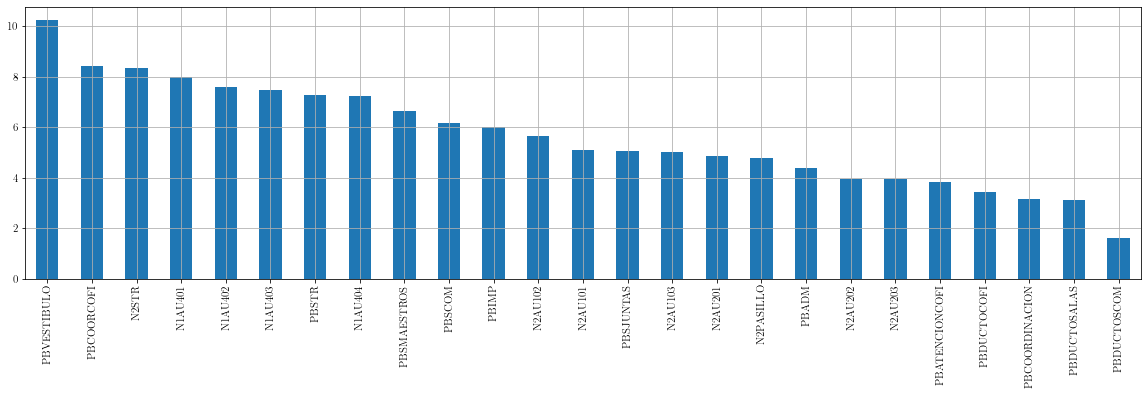

In [7]:

df=(sim_base3.resample('D').max()-sim_base3.resample('D').min()).resample('Y').mean()
df=df.T.sort_values(by=['2018-12-31'],ascending=False)
# df=df.sort_values()
df['2018-12-31'].plot.bar(figsize=(20,5))
plt.grid()

In [67]:
high_thermal_zones=['N2STR','N1AU401','PBVESTIBULO']
low_thermal_zones=['N2AU203','N1AU404','PBCOORDINACION']
dias=['2018-01-30 07:20:00',
      '2018-01-12 07:20:00',
      '2018-06-15 06:10:00',
      '2018-04-17 06:30:00',
      '2018-08-12 06:30:00',
      '2018-07-19 06:20:00',
      '2018-11-14 06:50:00',
      '2018-12-21 07:10:00']

In [68]:
dias

['2018-01-30 07:20:00',
 '2018-01-12 07:20:00',
 '2018-06-15 06:10:00',
 '2018-04-17 06:30:00',
 '2018-08-12 06:30:00',
 '2018-07-19 06:20:00',
 '2018-11-14 06:50:00',
 '2018-12-21 07:10:00']

In [69]:
def actualizar_bitacora(infodf,cols_gen,path,nombre_archivo): #adds a new row on a predetermined dataframe 
    df=pd.read_csv(path+nombre_archivo)
    infodf=pd.DataFrame(data=infodf,columns=cols_gen)
    newdf=pd.concat([df,infodf])
    newdf=newdf.set_index('Maximum_error')
    newdf.to_csv(path+nombre_archivo)
    return(pd.read_csv((path+nombre_archivo)))


In [70]:
def simulation_metrics(df_base,df2,dias,dia,tolerance,zt):
        df_inic=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('13H'):parse(dias[dia])+pd.Timedelta('100D')]
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('13H'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean()
        df_rolled.loc[df_rolled[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
        df_end=df_rolled[df_rolled.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
        df_diff=df_inic.loc[parse(dias[dia])+pd.Timedelta('50Min'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean().diff()
        i=0
        while(True):
            i=i+1
            df_end_index=str(df_end.index[i])
            if df_diff[zt].loc[df_end_index]<0:
                break
        vanish_time1=(pd.Timedelta(df_end.index[i]-parse(dias[dia])))
        vanish_time=vanish_time1.days+vanish_time1.seconds/(60*60*24)
#         print('vanish_time:',vanish_time)
        max_index_error=parse(str(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time1)].idxmax()))
        max_error=df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time1)].max()
        max_time=pd.Timedelta(max_index_error-parse(dias[dia]))
        down_time=df_end.index[i]-max_index_error
    #     print('tiempo de maximo error:',max_index_error)
    #     print('tiempo para maximo error:',max_time)
    #     print('tiempo de bajada:',down_time)
    #     print('valor maximo de error:',max_error)

        return(vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff)

In [71]:
tolerance=.1
heio=0
# dias=sim_base3.index
for tz in range (0,len(tzs),1):
    
    thermal_zone=tzs[tz]
    plus='infiltration_ocupation'
    path_metrics='02_simulation_metrics/'
    file_metrics='impmetrics'+plus+'.csv'
    sim_imputed=sim_ann_imp3
    sim_base=sim_base3
    save=True
    dia=4

#     wdays=sim_base3.index
    for dia in range(len(dias)):
#     for dia in (wdays):
        vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
        sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
#         print(thermal_zone)
        if save==True:
            print('tz',tz)
            if heio==0:
                heio=1
                first=np.array([thermal_zone,dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,7)
                cols=['thermal_zone','Date_imputed','vanishing_time','Maximum_error','Time of maximum error','Time_for_maximum_error','Time from maximum to tolerated error']
                simulation_met=pd.DataFrame(first,columns=cols)
                simulation_met=simulation_met.set_index('Maximum_error')
                simulation_met.to_csv(path_metrics+file_metrics)
            else:
                first=np.array([thermal_zone,dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,7)
                actualizar_bitacora(first,cols,path_metrics,file_metrics)

tz 0
tz 0
tz 0
tz 0
tz 0
tz 0
tz 0
tz 0
tz 1
tz 1
tz 1
tz 1
tz 1
tz 1
tz 1
tz 1
tz 2
tz 2
tz 2
tz 2
tz 2
tz 2
tz 2
tz 2
tz 3
tz 3
tz 3
tz 3
tz 3
tz 3
tz 3
tz 3
tz 4
tz 4
tz 4
tz 4
tz 4
tz 4
tz 4
tz 4
tz 5
tz 5
tz 5
tz 5
tz 5
tz 5
tz 5
tz 5
tz 6
tz 6
tz 6
tz 6
tz 6
tz 6
tz 6
tz 6
tz 7
tz 7
tz 7
tz 7
tz 7
tz 7
tz 7
tz 7
tz 8
tz 8
tz 8
tz 8
tz 8
tz 8
tz 8
tz 8
tz 9
tz 9
tz 9
tz 9
tz 9
tz 9
tz 9
tz 9
tz 10
tz 10
tz 10
tz 10
tz 10
tz 10
tz 10
tz 10
tz 11
tz 11
tz 11
tz 11
tz 11
tz 11
tz 11
tz 11
tz 12
tz 12
tz 12
tz 12
tz 12
tz 12
tz 12
tz 12
tz 13
tz 13
tz 13
tz 13
tz 13
tz 13
tz 13
tz 13
tz 14
tz 14
tz 14
tz 14
tz 14
tz 14
tz 14
tz 14
tz 15
tz 15
tz 15
tz 15
tz 15
tz 15
tz 15
tz 15
tz 16
tz 16
tz 16
tz 16
tz 16
tz 16
tz 16
tz 16
tz 17
tz 17
tz 17
tz 17
tz 17
tz 17
tz 17
tz 17
tz 18
tz 18
tz 18
tz 18
tz 18
tz 18
tz 18
tz 18
tz 19
tz 19
tz 19
tz 19
tz 19
tz 19
tz 19
tz 19
tz 20
tz 20
tz 20
tz 20
tz 20
tz 20
tz 20
tz 20
tz 21
tz 21
tz 21
tz 21
tz 21
tz 21
tz 21
tz 21
tz 22
tz 22
tz 22
tz 22


In [72]:
dia_7=pd.read_csv(path_metrics+file_metrics,index_col=1).sort_values(by='vanishing_time',ascending=True)

# dia_7=dia_7.set_index(dia_7='vanishing_time')
dia_7=dia_7.groupby(by='thermal_zone').mean().sort_values(by='vanishing_time')
dia_7

Maximum_error  vanishing_time
thermal_zone                                 
PBCOORCOFI           2.287129        1.796007
PBIMP                1.254499        1.878472
PBATENCIONCOFI       0.457661        2.059896
PBVESTIBULO          2.718706        2.068576
PBSCOM               0.912638        2.085938
PBCOORDINACION       0.583317        2.269965
PBSMAESTROS          1.453131        2.434896
PBDUCTOCOFI          1.063142        2.578125
PBSTR                0.951140        2.627604
PBADM                0.905665        2.635417
PBSJUNTAS            0.902918        2.809028
N1AU401              0.715358        2.914062
PBDUCTOSALAS         1.059148        2.954861
N1AU404              0.711934        2.996528
N2STR                0.926756        3.104167
PBDUCTOSCOM          0.516526        3.131076
N1AU403              0.779902        3.210938
N1AU402              0.757490        3.233507
N2PASILLO            0.303034        3.235243
N2AU201              0.714206        3.349826
N2AU101              0.878456        3.416667
N2AU102              0.865269        3.493056
N2AU103              0.889908        3.504340
N2AU203              0.691326        3.715278
N2AU202              0.705239        3.745660

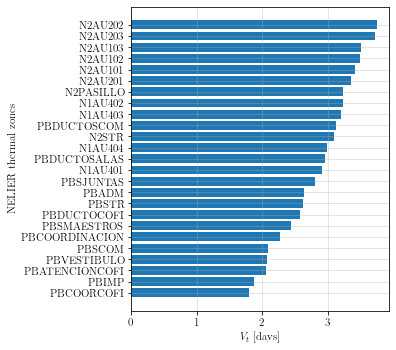

In [73]:
fig,ax=plt.subplots(figsize=(5.63,5))
plt.barh(dia_7.index, dia_7.vanishing_time)#,'b.-',markersize=20)
ax.set_ylabel('NELIER thermal zones')
ax.set_xlabel('$V_t$ [days]')
ax.grid(alpha=.4)
plt.tight_layout()
# plt.savefig('../../../Tesis_repo/figures/tzs_vt.pdf')

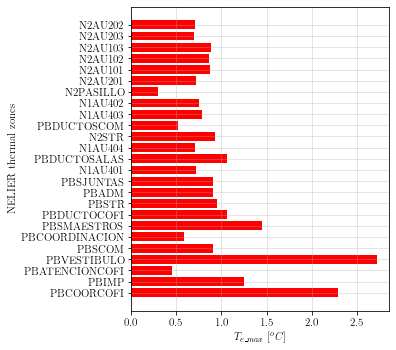

In [74]:
fig,ax=plt.subplots(figsize=(5.63,5))
plt.barh(dia_7.index, dia_7.Maximum_error,color='red')#,'b.-',markersize=20)
ax.set_ylabel('NELIER thermal zones')
ax.set_xlabel('$T_{e\_max}$ [$^oC$]')
ax.grid(alpha=.4)
plt.tight_layout()
# plt.savefig('../../../Tesis_repo/figures/max_error_vt.pdf')


In [14]:
def simulation_metrics(df_base,df2,dias,dia,tolerance,zt):
        df_inic=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('13H'):parse(dias[dia])+pd.Timedelta('100D')]
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('13H'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean()
        df_rolled.loc[df_rolled[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
        df_end=df_rolled[df_rolled.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
        df_diff=df_inic.loc[parse(dias[dia])+pd.Timedelta('50Min'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean().diff()
        i=0
        while(True):
            i=i+1
            df_end_index=str(df_end.index[i])
            if df_diff[zt].loc[df_end_index]<0:
                break
        vanish_time1=(pd.Timedelta(df_end.index[i]-parse(dias[dia])))
#         vanish_time=vanish_time1.days+vanish_time1.seconds/(60*60*24)
        print('vanish_time:',vanish_time)
        max_index_error=parse(str(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time1)].idxmax()))
        max_error=df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time1)].max()
        max_time=pd.Timedelta(max_index_error-parse(dias[dia]))
        down_time=df_end.index[i]-max_index_error
    #     print('tiempo de maximo error:',max_index_error)
    #     print('tiempo para maximo error:',max_time)
    #     print('tiempo de bajada:',down_time)
    #     print('valor maximo de error:',max_error)

        return(vanish_time1,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff)

vanish_time: 2.7708333333333335
N2STR


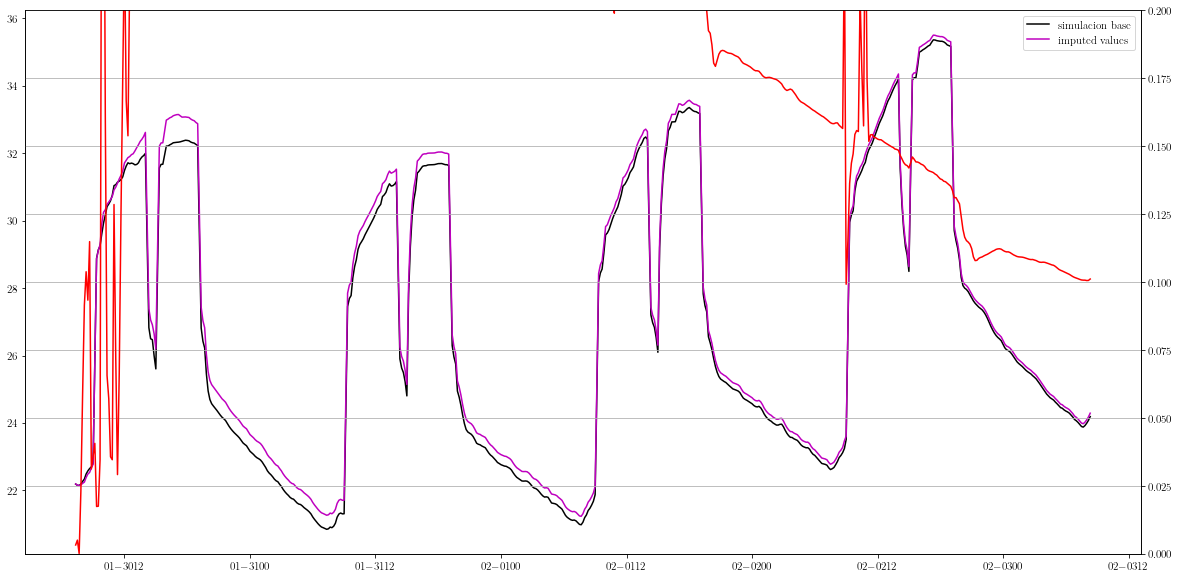

vanish_time: 4 days 01:00:00
N2STR


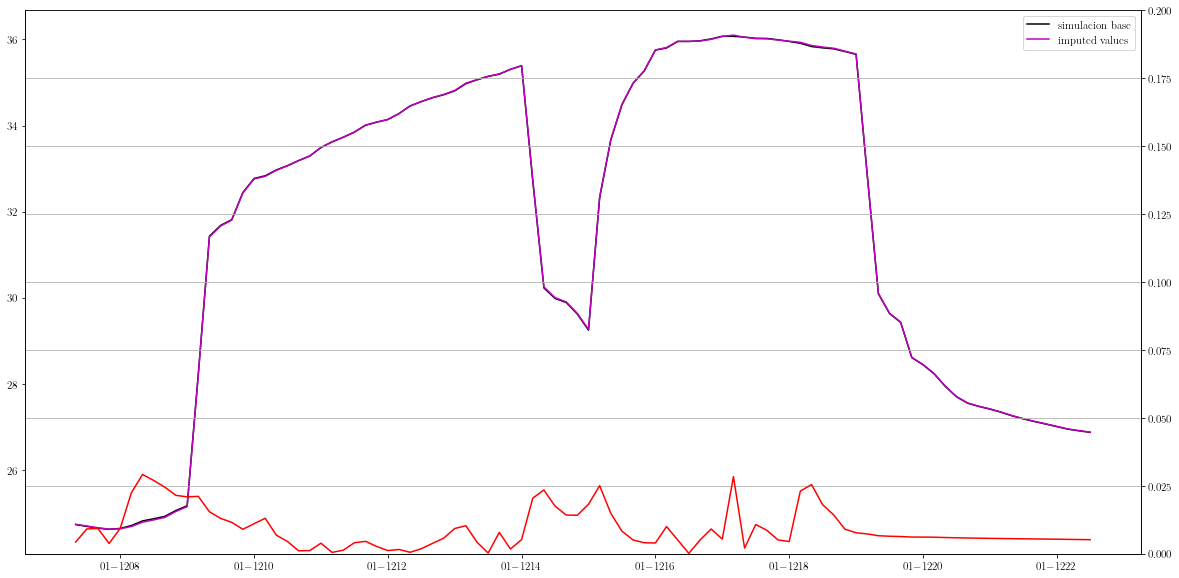

vanish_time: 0 days 15:10:00
N2STR


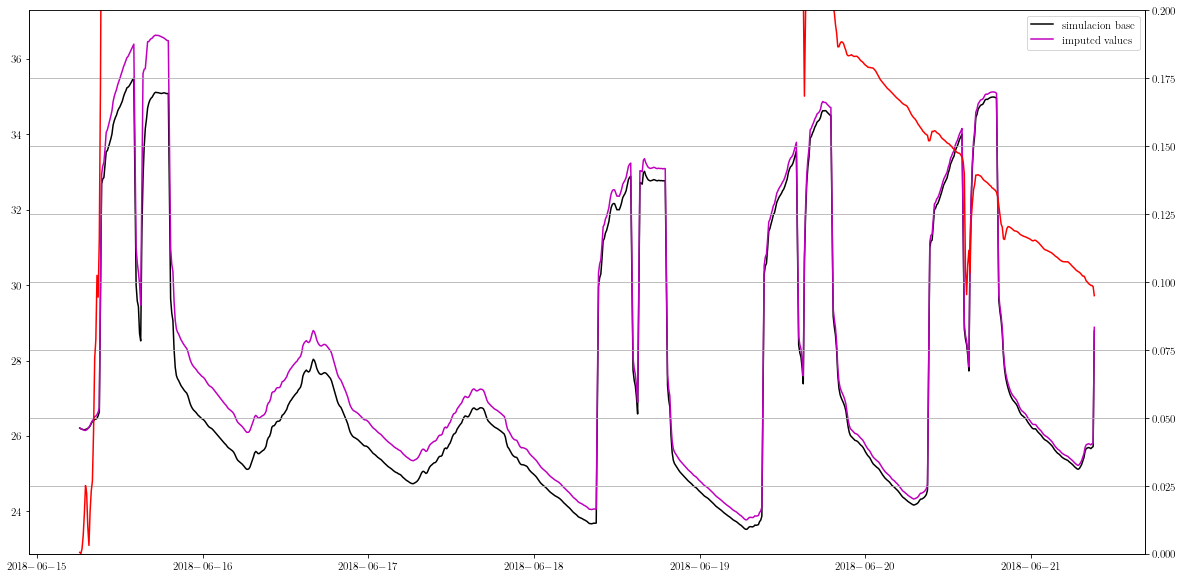

vanish_time: 6 days 03:00:00
N2STR


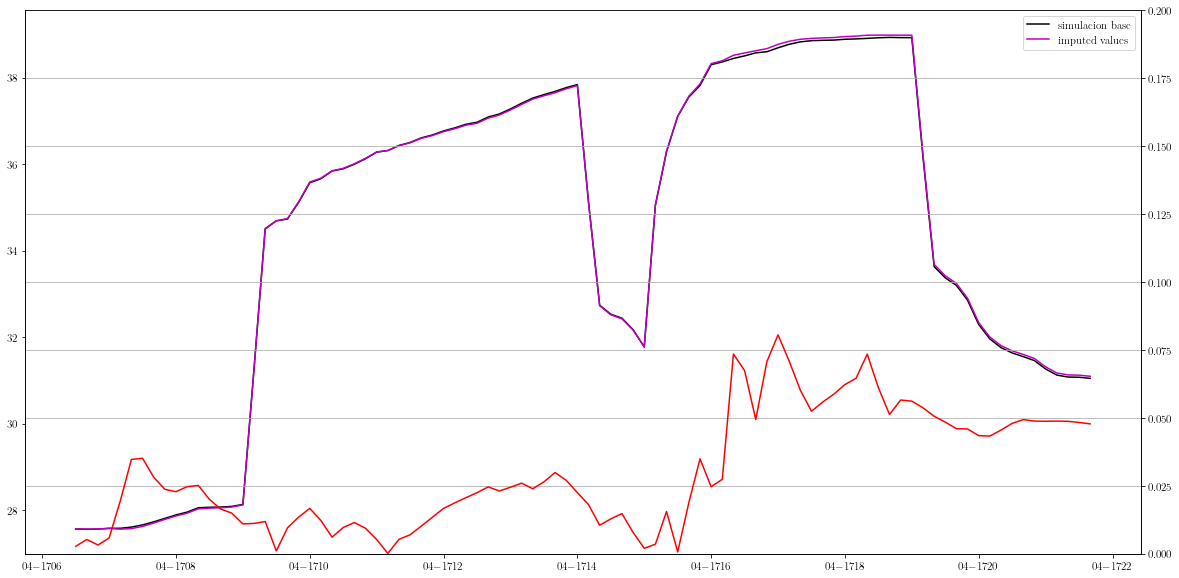

vanish_time: 0 days 15:10:00
N2STR


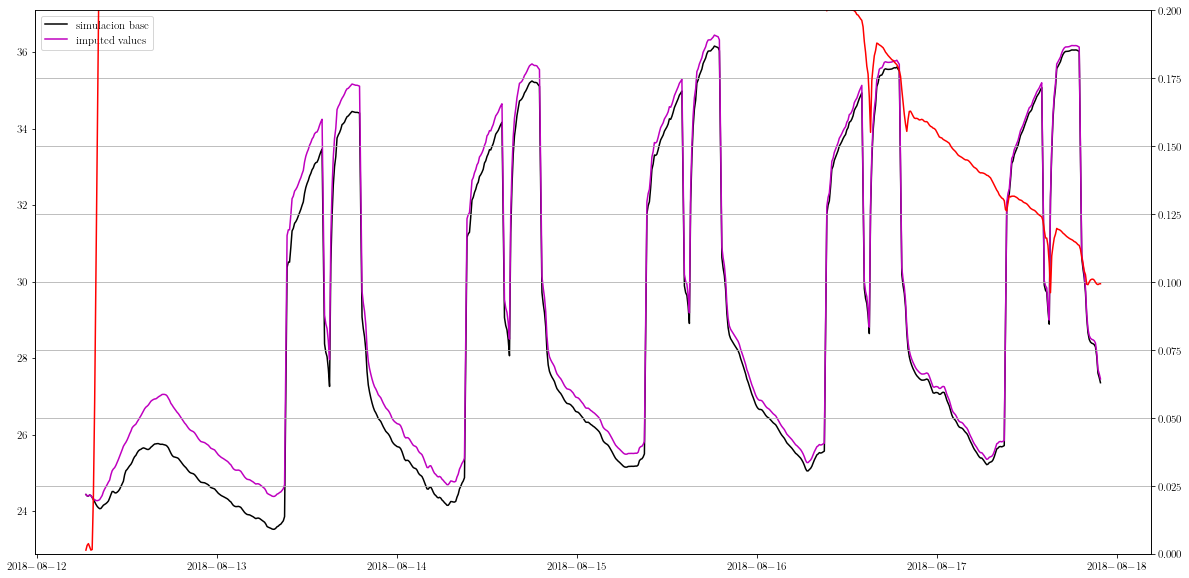

vanish_time: 5 days 15:20:00
N2STR


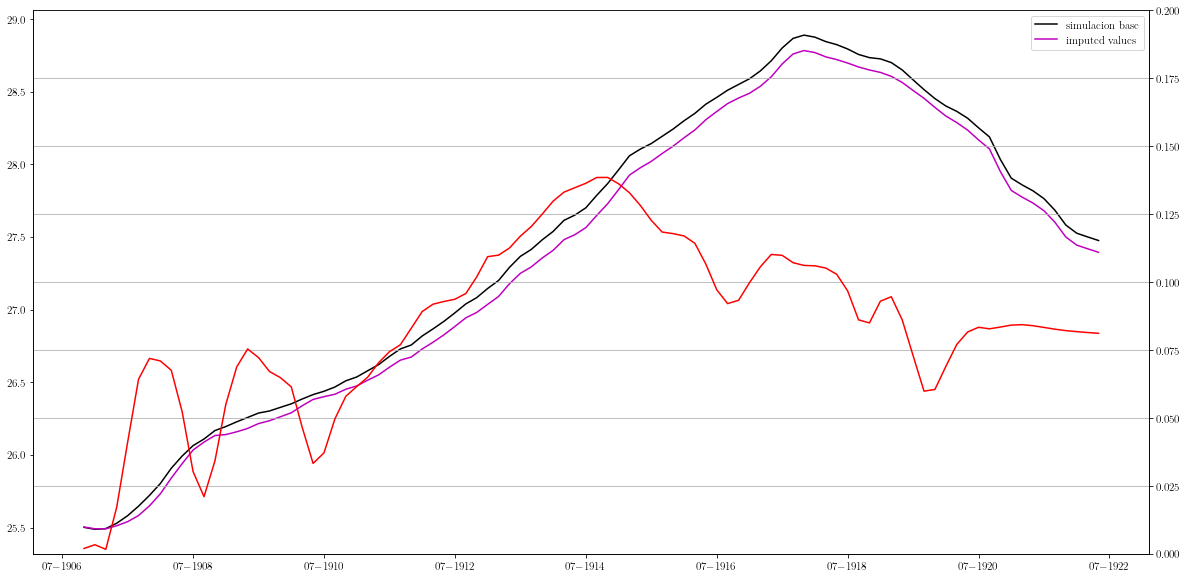

vanish_time: 0 days 15:30:00
N2STR


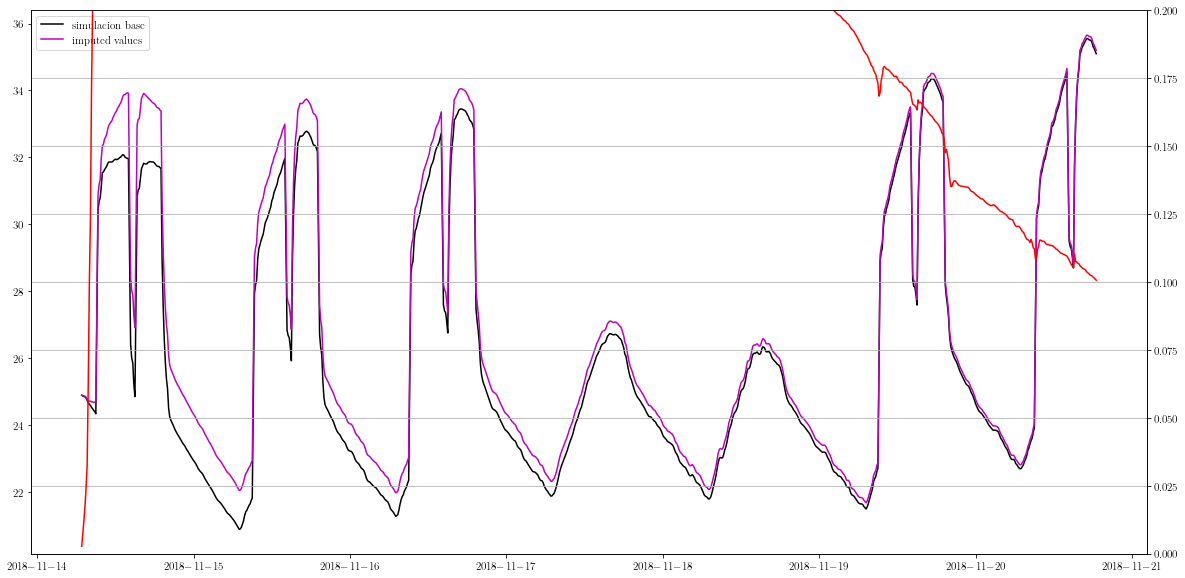

vanish_time: 6 days 11:40:00
N2STR


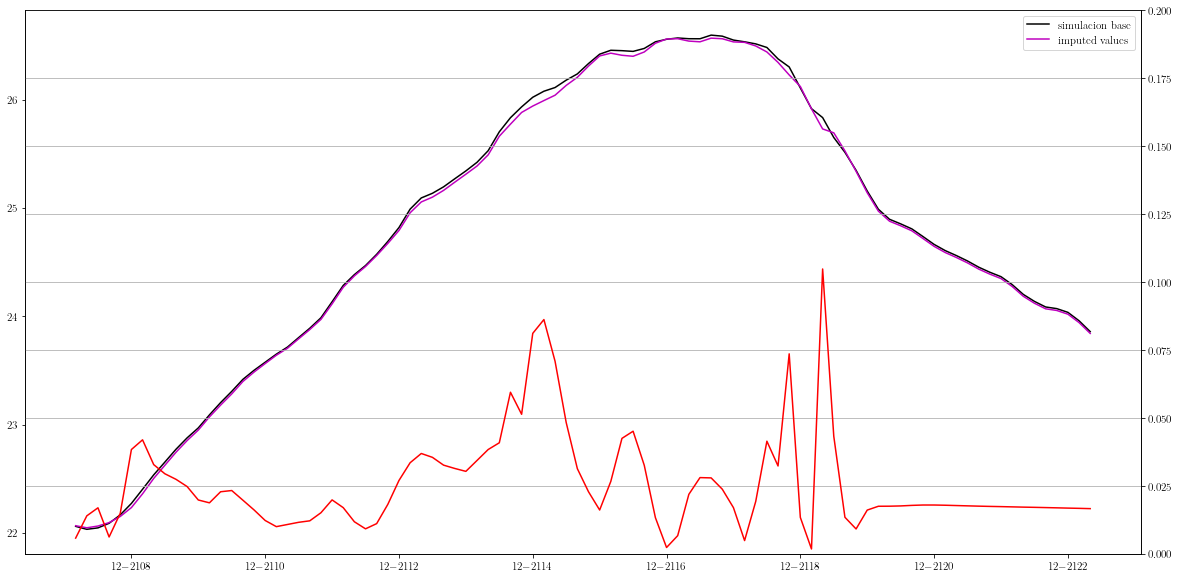

vanish_time: 0 days 15:10:00
N1AU401


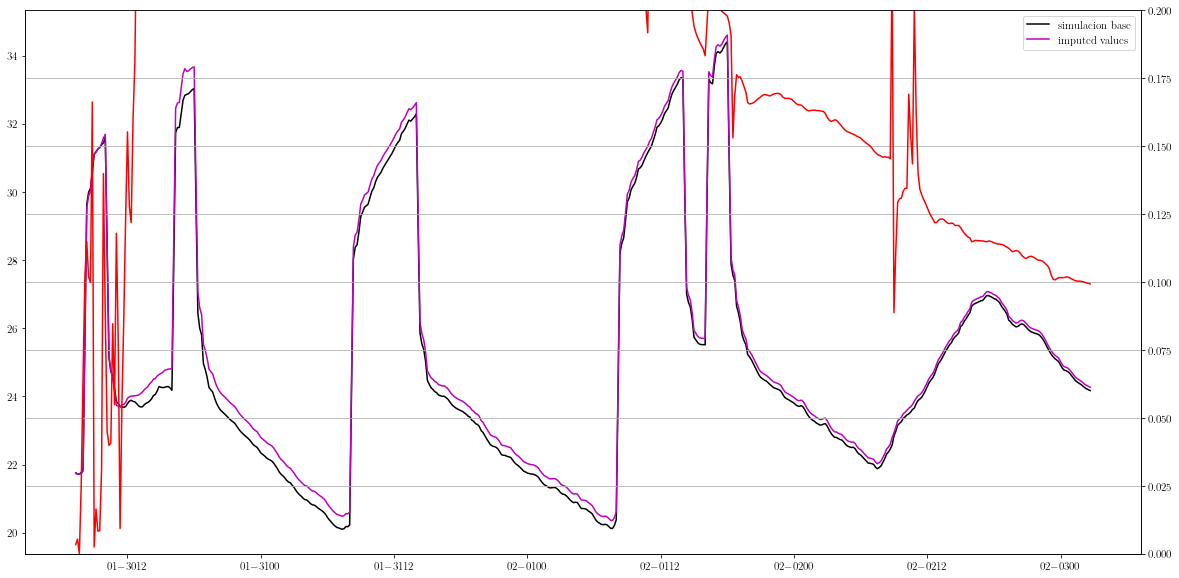

vanish_time: 3 days 19:20:00
N1AU401


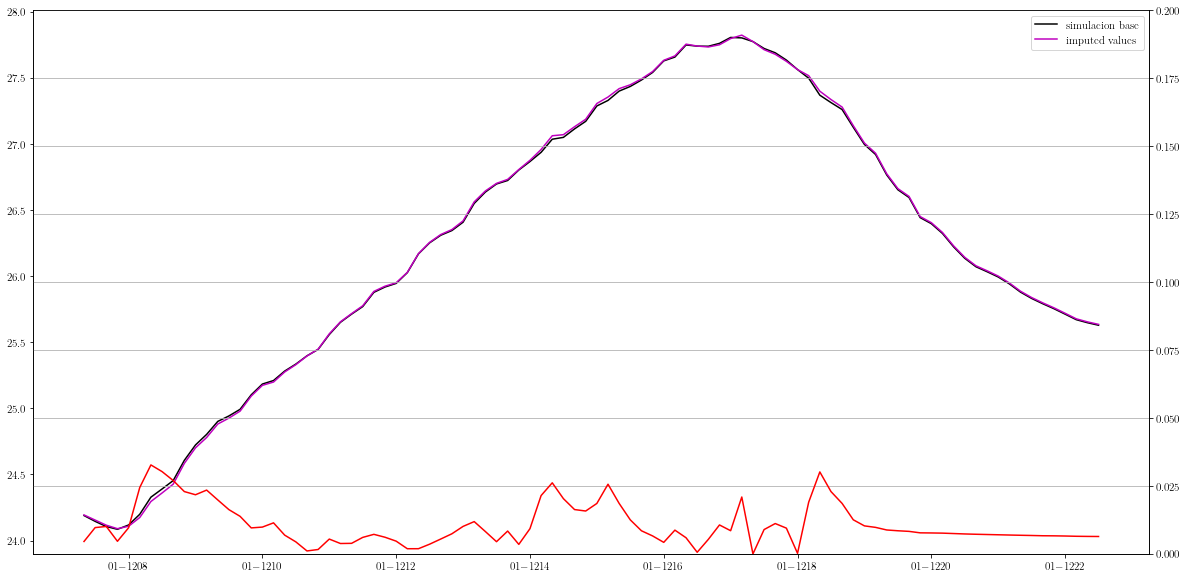

vanish_time: 0 days 15:10:00
N1AU401


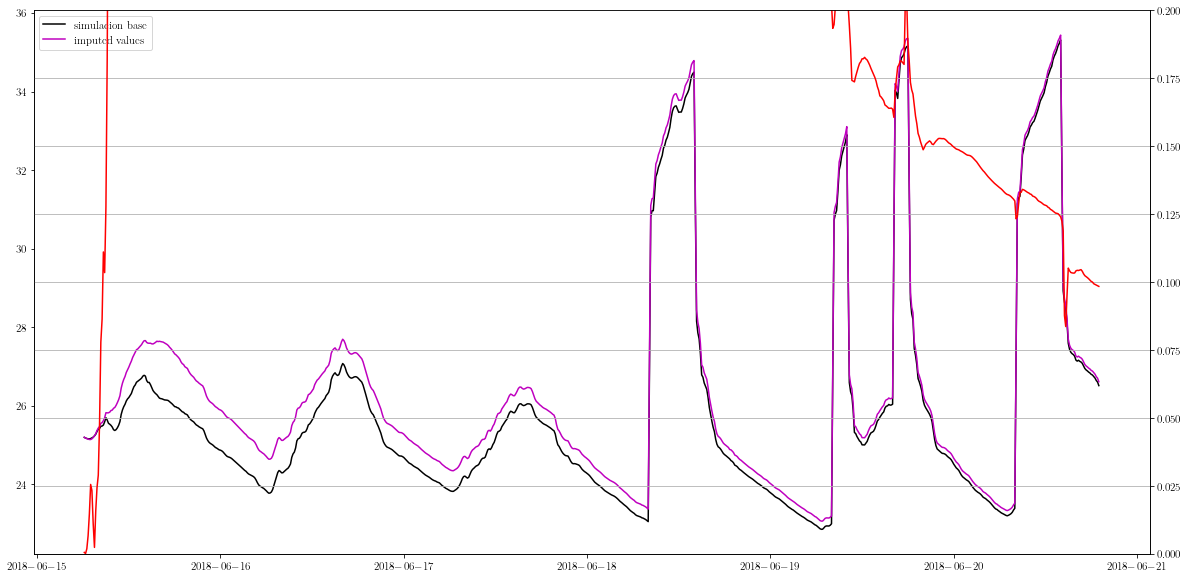

vanish_time: 5 days 12:50:00
N1AU401


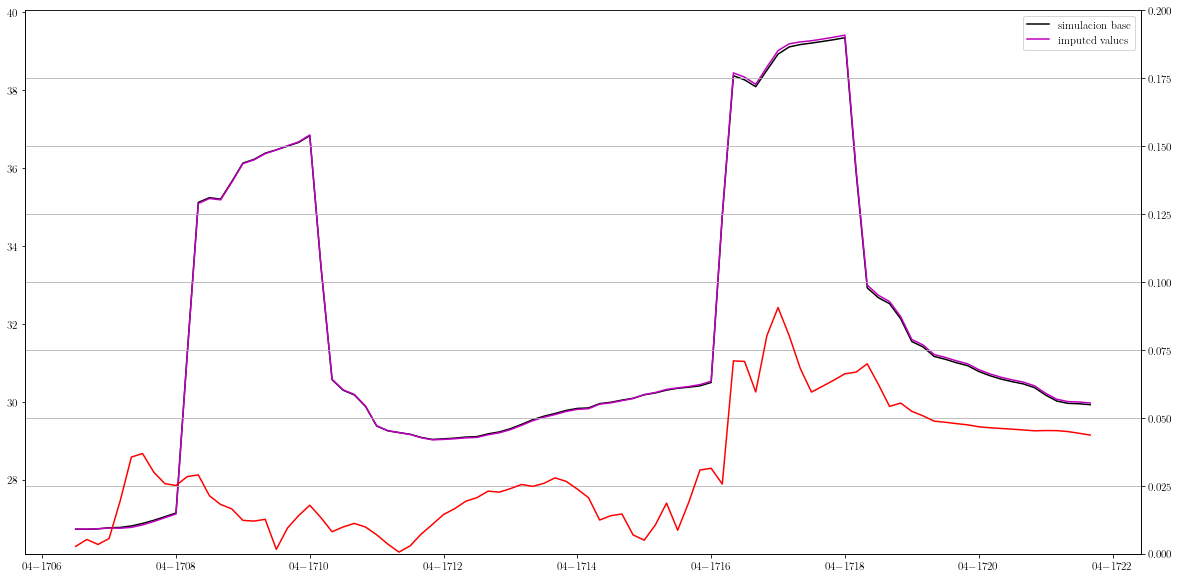

vanish_time: 0 days 15:10:00
N1AU401


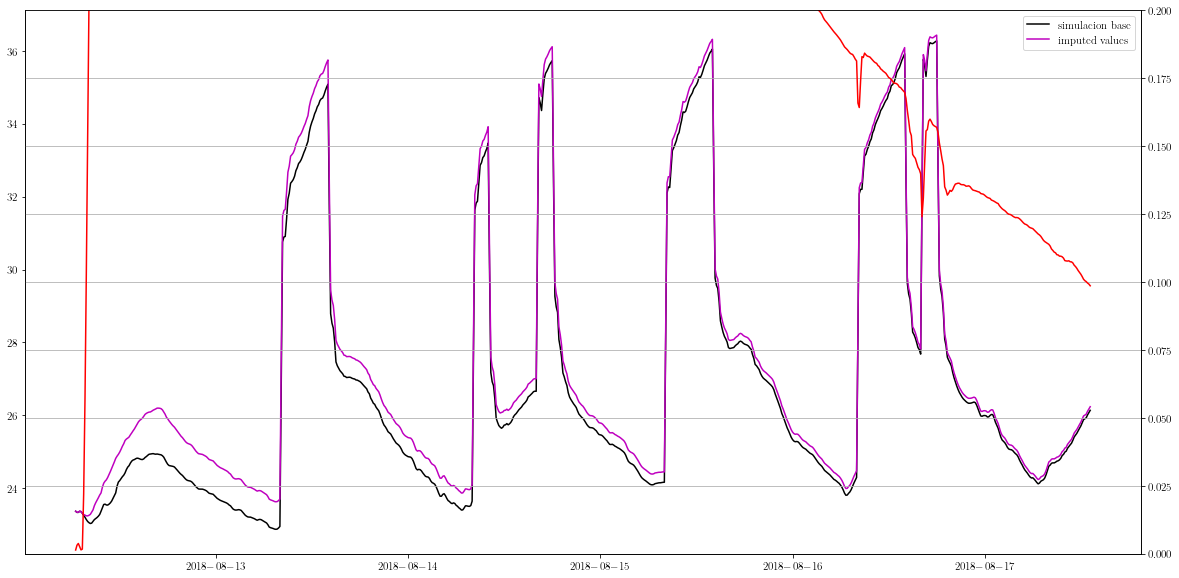

vanish_time: 5 days 06:40:00
N1AU401


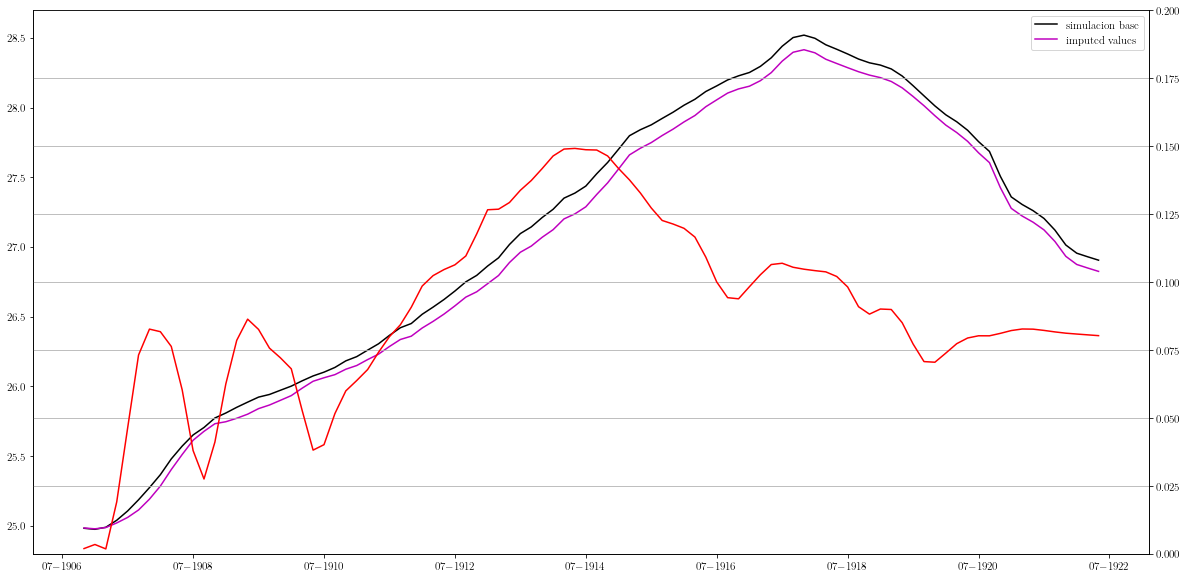

vanish_time: 0 days 15:30:00
N1AU401


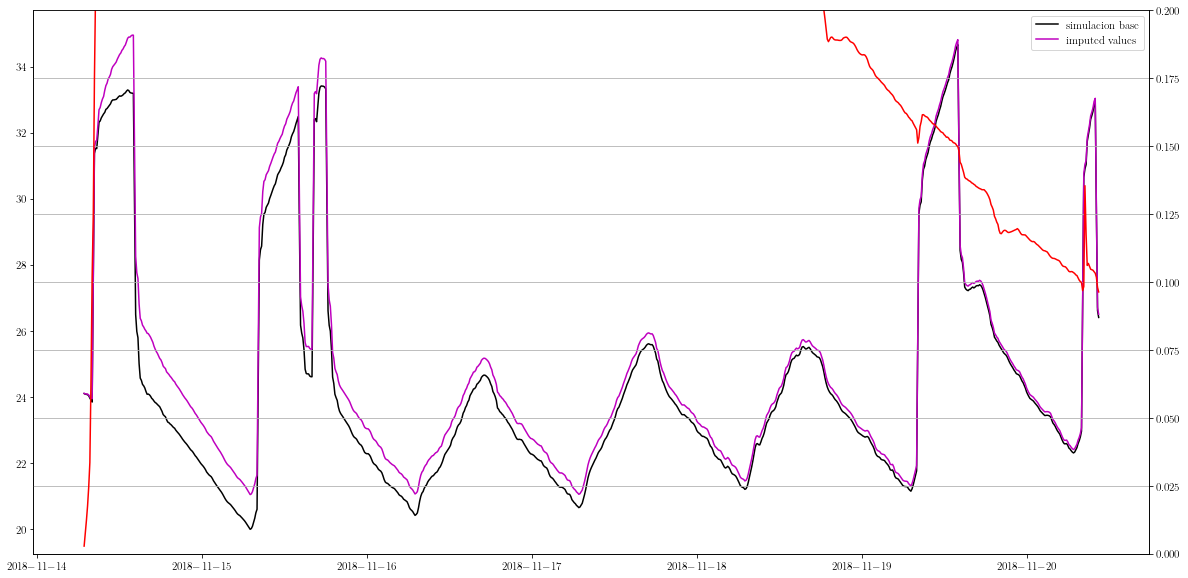

vanish_time: 6 days 03:40:00
N1AU401


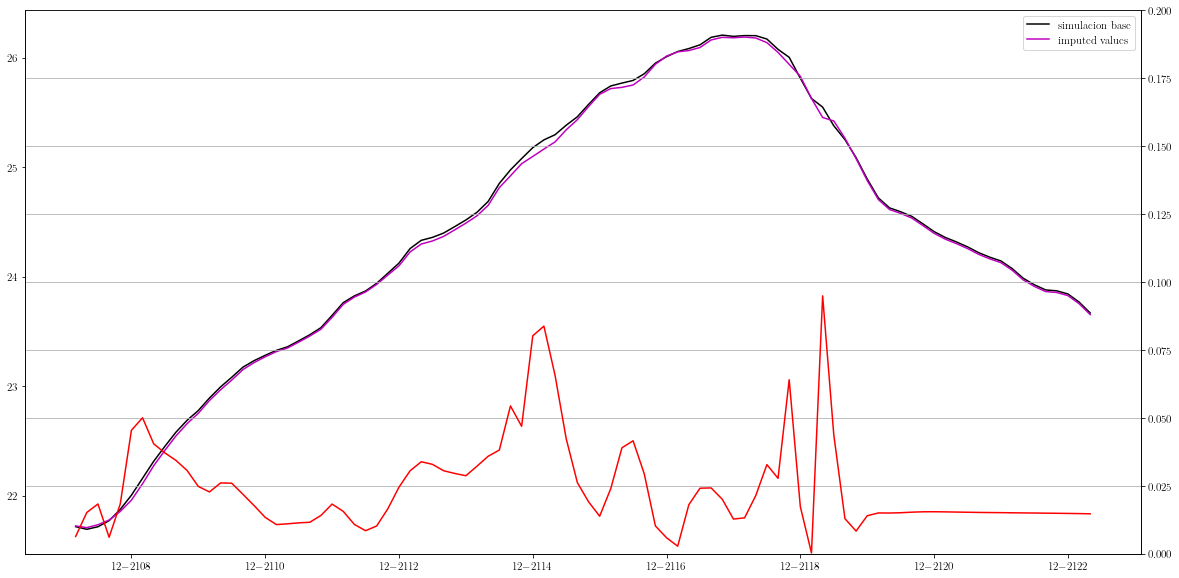

vanish_time: 0 days 15:10:00
PBVESTIBULO


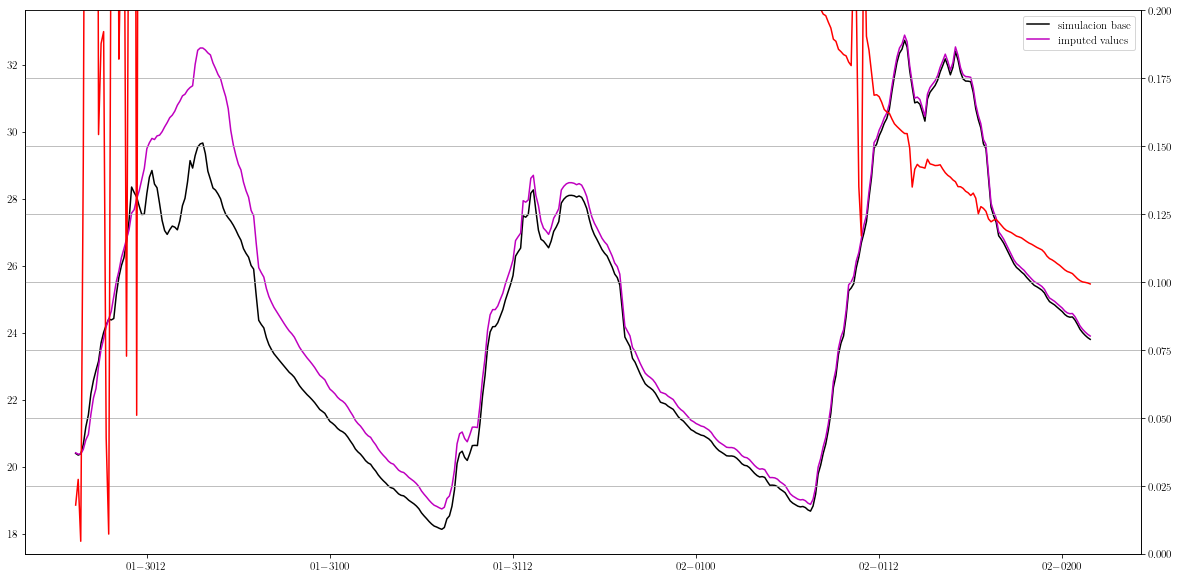

vanish_time: 2 days 18:30:00
PBVESTIBULO


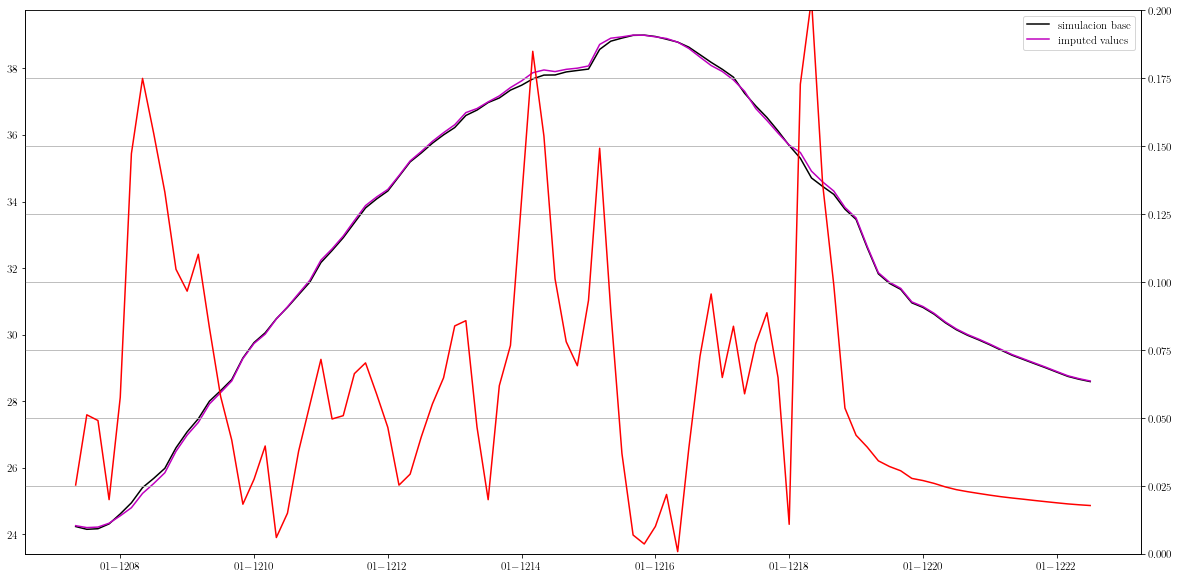

vanish_time: 0 days 15:10:00
PBVESTIBULO


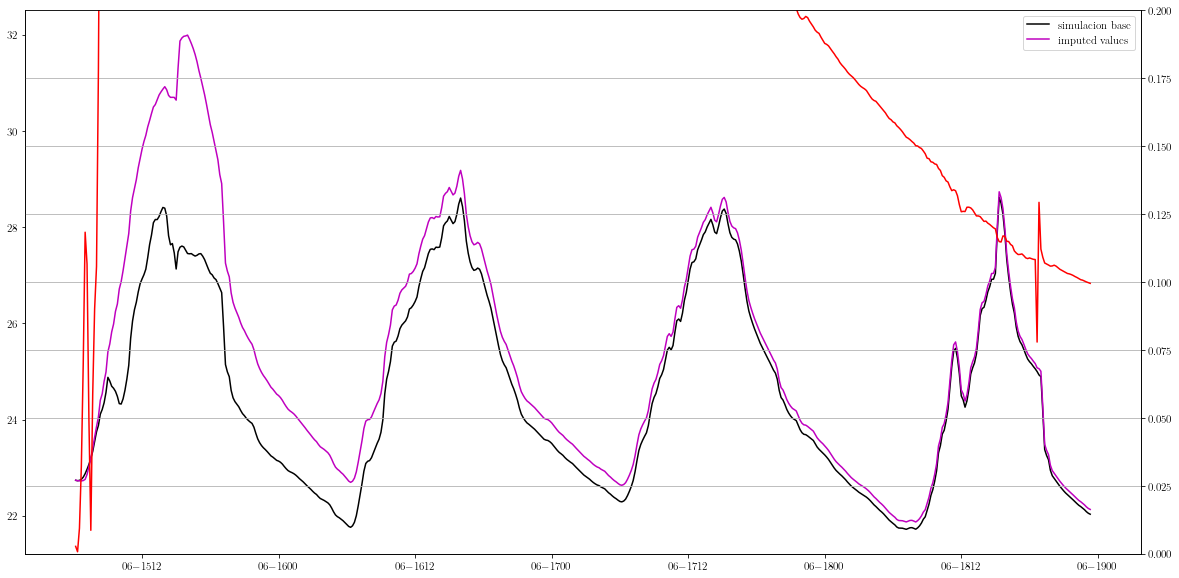

vanish_time: 3 days 17:10:00
PBVESTIBULO


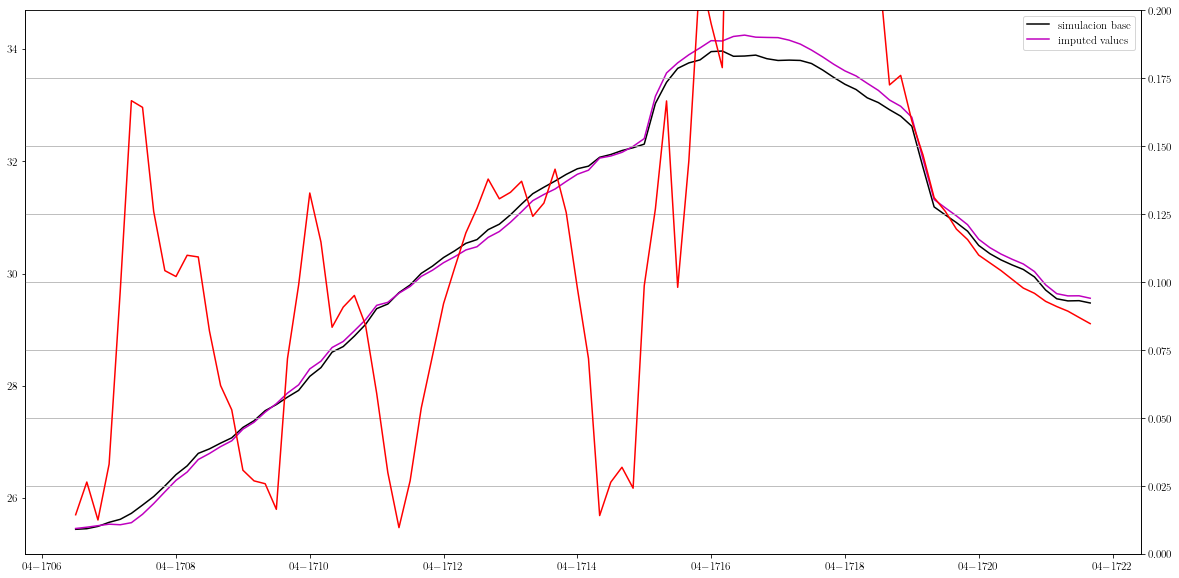

vanish_time: 0 days 15:10:00
PBVESTIBULO


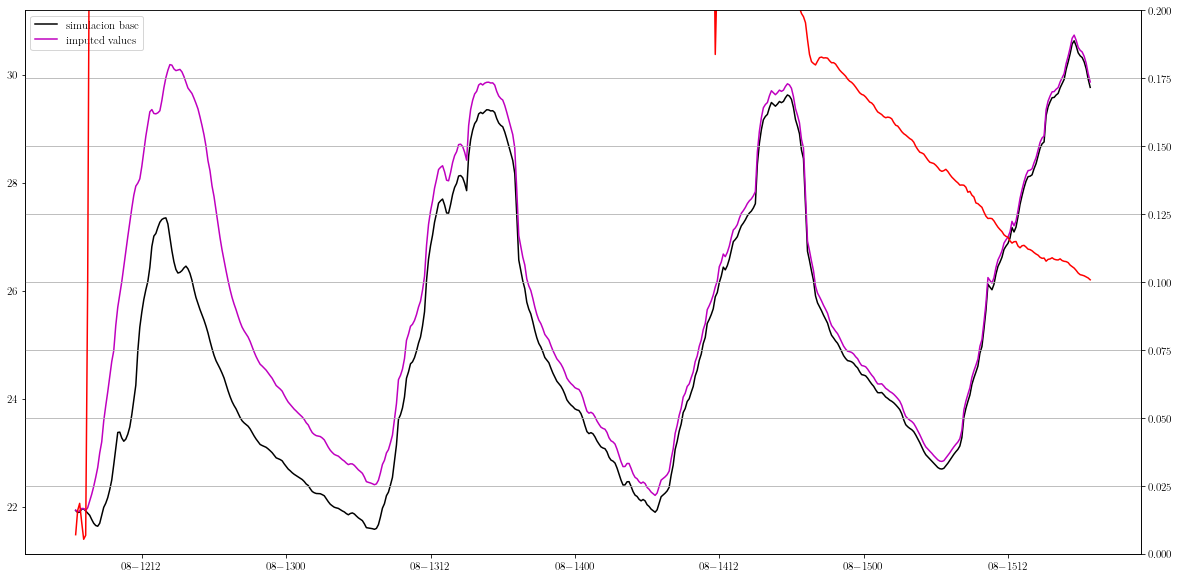

vanish_time: 3 days 12:20:00
PBVESTIBULO


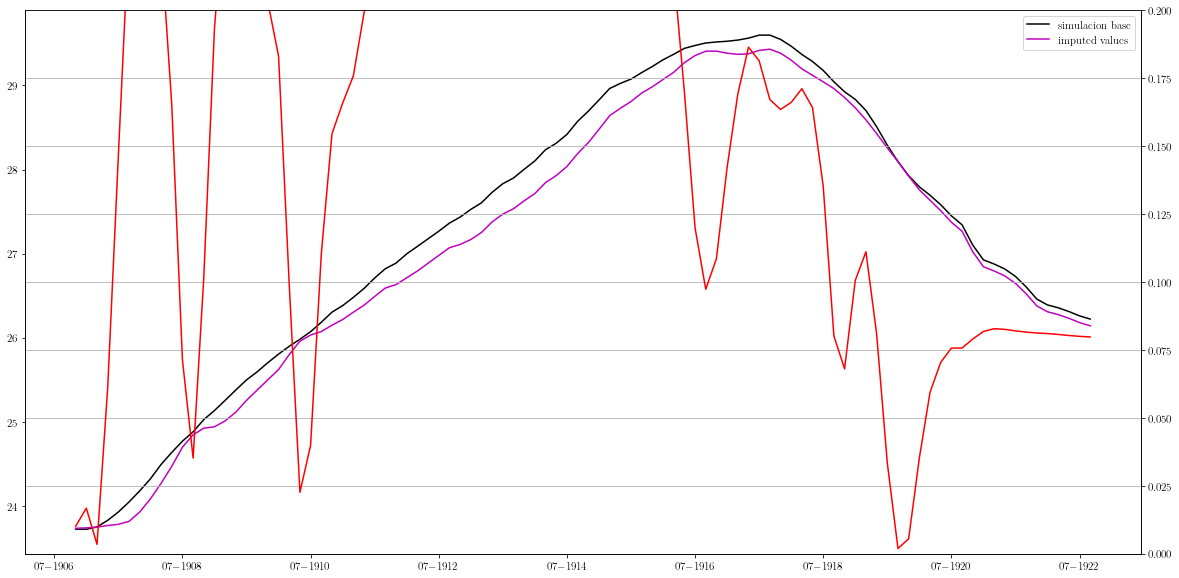

vanish_time: 0 days 15:50:00
PBVESTIBULO


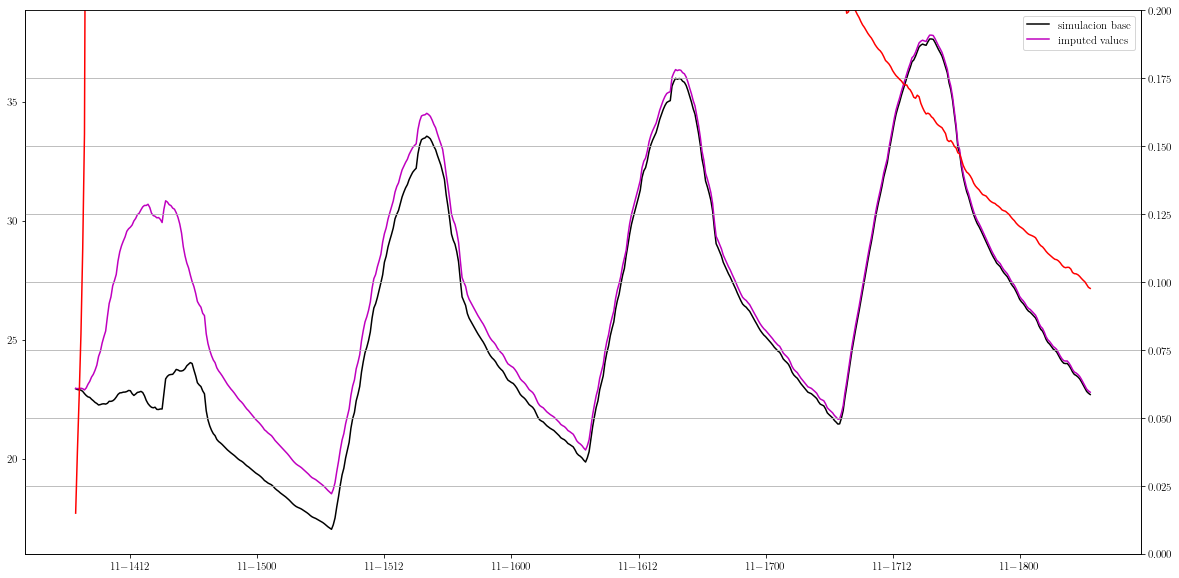

vanish_time: 3 days 23:50:00
PBVESTIBULO


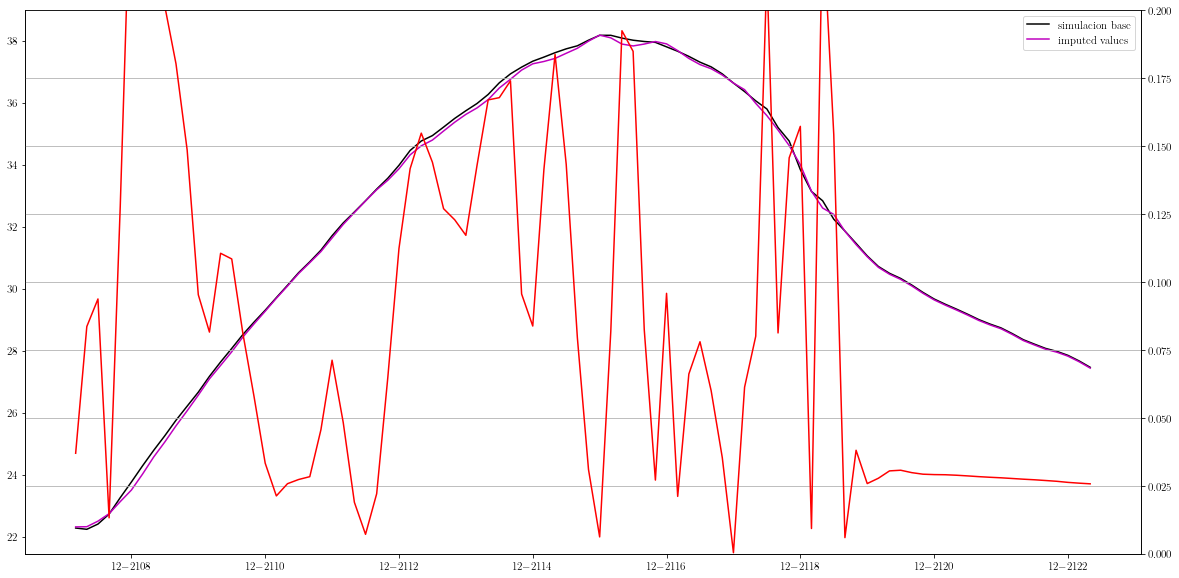

In [15]:
tolerance=.1
for tz in range (0,3,1):
    
    thermal_zone=high_thermal_zones[tz]
    plus='infiltration_ocupation'
    # 'N1AU404'
    # 'PBSCOM'
    path_metrics='02_simulation_metrics/'
    file_metrics='ann_imputation_metrics'+high_thermal_zones[tz]+plus+'.csv'
    tz=thermal_zone
    sim_imputed=sim_ann_imp3
    sim_base=sim_base3
    save=True
    for dia in range(len(dias)):
        vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
        sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
        print(thermal_zone)
        fig, ax=plt.subplots(figsize=(20,10))
        ax.plot(sim_base[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
        ax2=ax.twinx()
        ax.plot(sim_imputed[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='imputed values')
        ax2.plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',label='error')
    #     ax2.plot(df_rolled[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='error_rolled')
        ax.legend()
        #ax2.legend()
        ax2.set_ylim(0,.2)
    #     ax.set_ylim(20,27)
        ax2.grid()
        plt.show()
        if save==True:
            if dia==0:
                first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
                cols=['Date_imputed','vanishing_time','Maximum_error','Time of maximum error','Time_for_maximum_error','Time from maximum to tolerated error']
                simulation_met=pd.DataFrame(first,columns=cols)
                simulation_met=simulation_met.set_index('Maximum_error')
                simulation_met.to_csv(path_metrics+file_metrics)
            else:
                first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
                actualizar_bitacora(first,cols,path_metrics,file_metrics)

vanish_time: 7 days 14:20:00
N2AU203


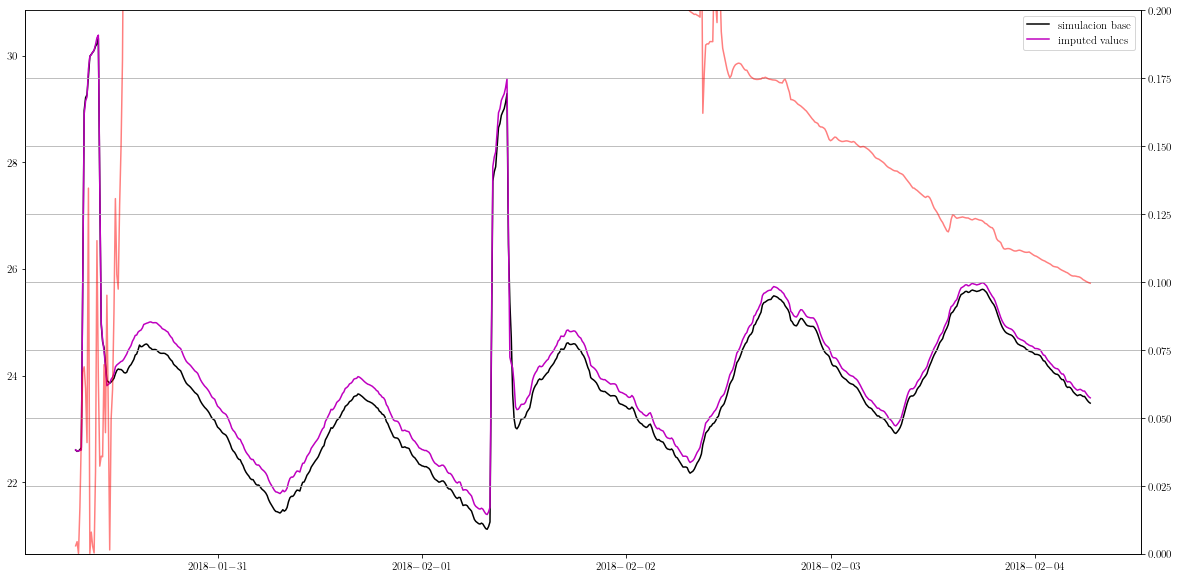

vanish_time: 4 days 23:10:00
N2AU203


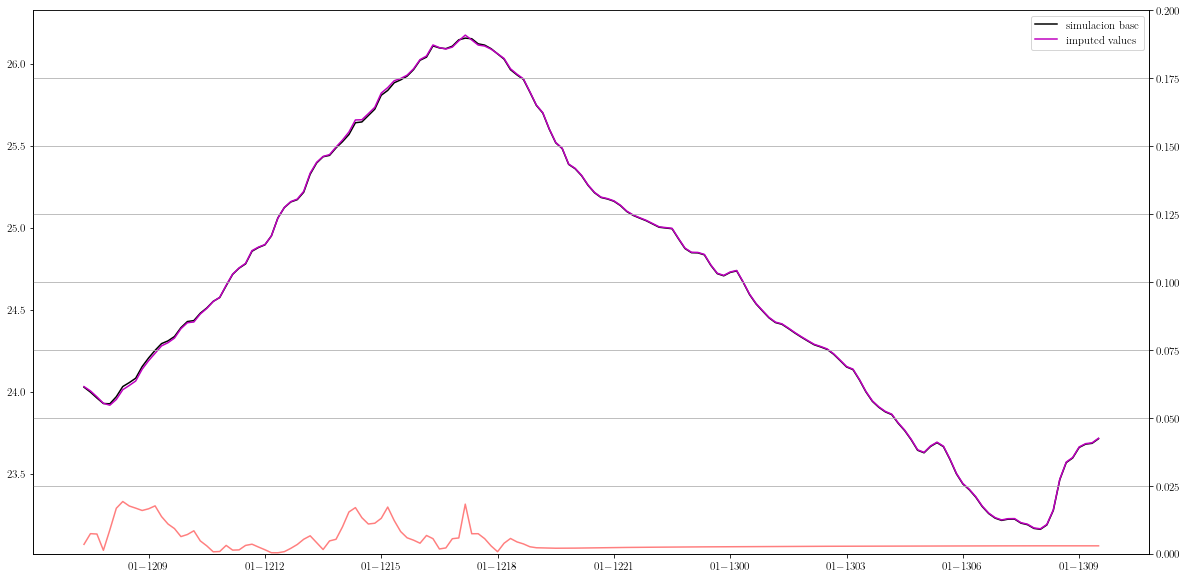

vanish_time: 1 days 02:10:00
N2AU203


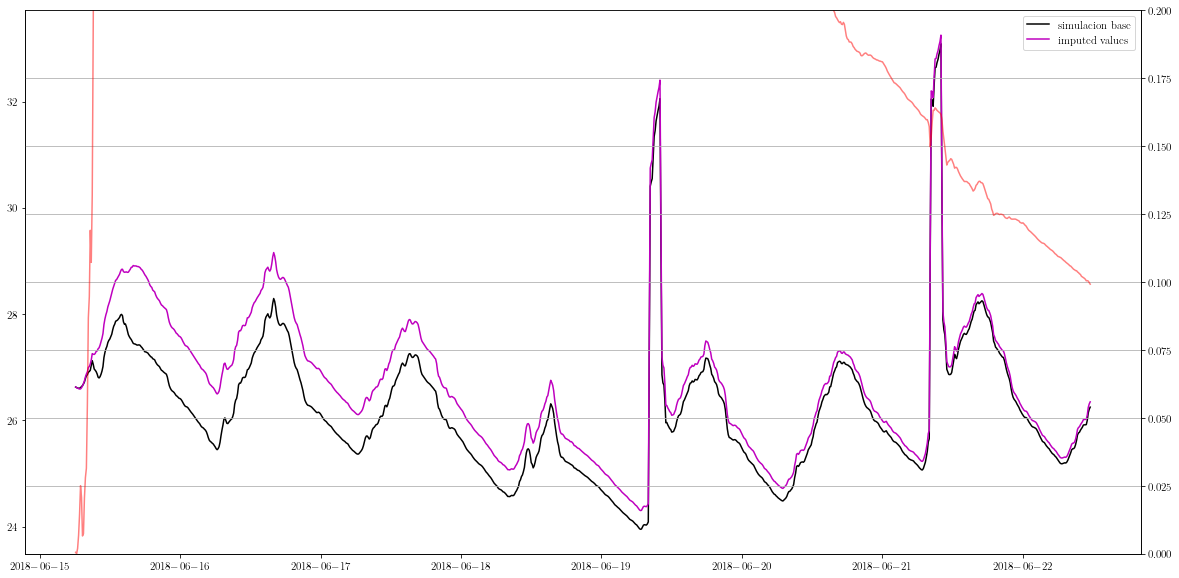

vanish_time: 7 days 05:20:00
N2AU203


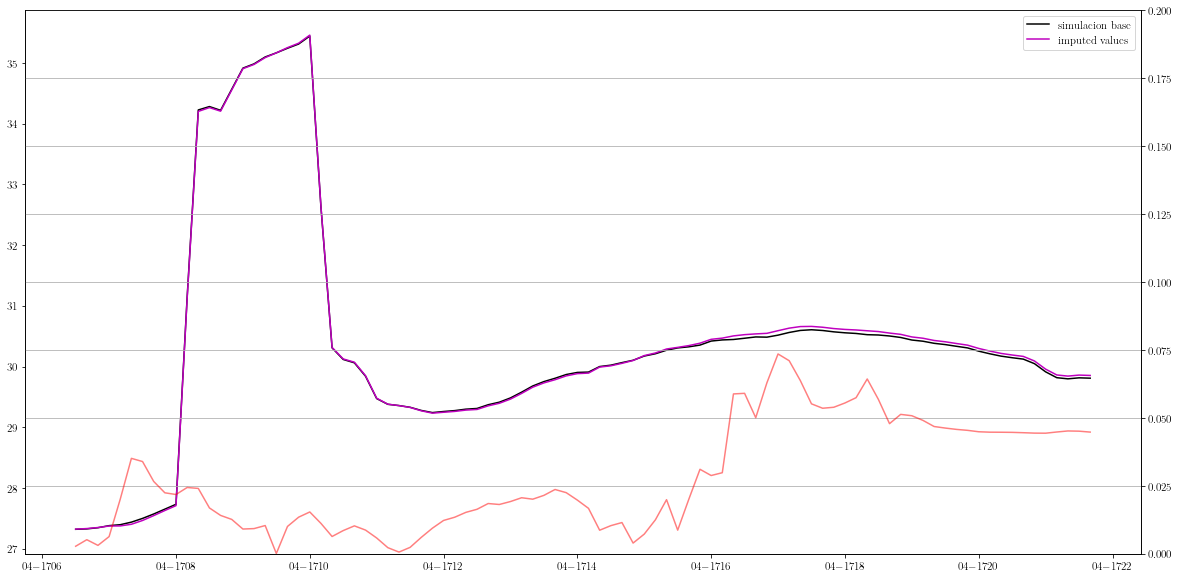

vanish_time: 0 days 15:10:00
N2AU203


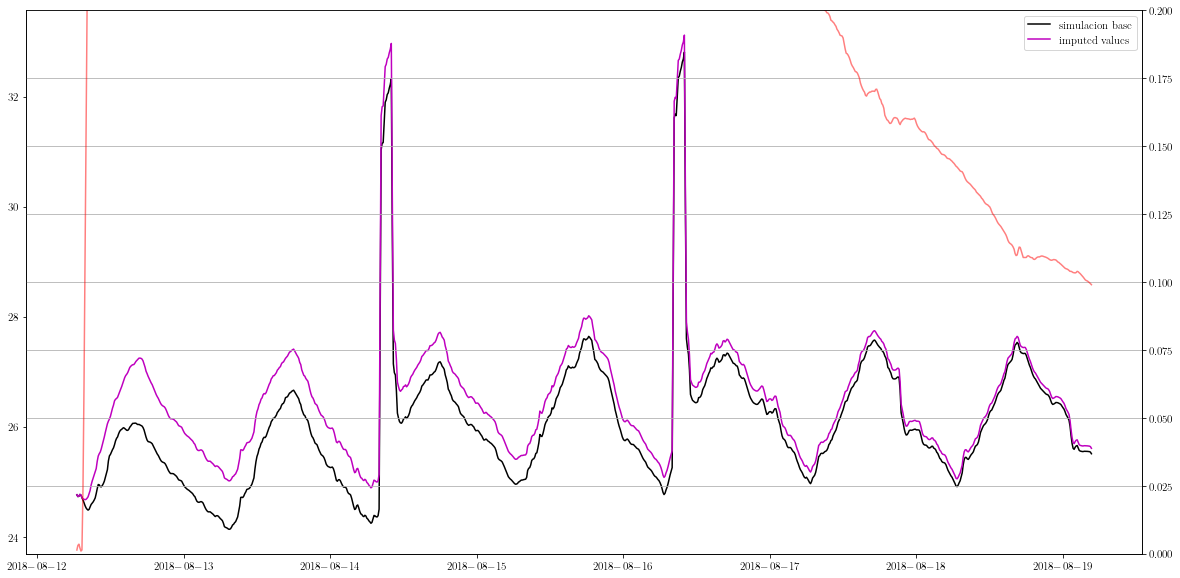

vanish_time: 6 days 22:10:00
N2AU203


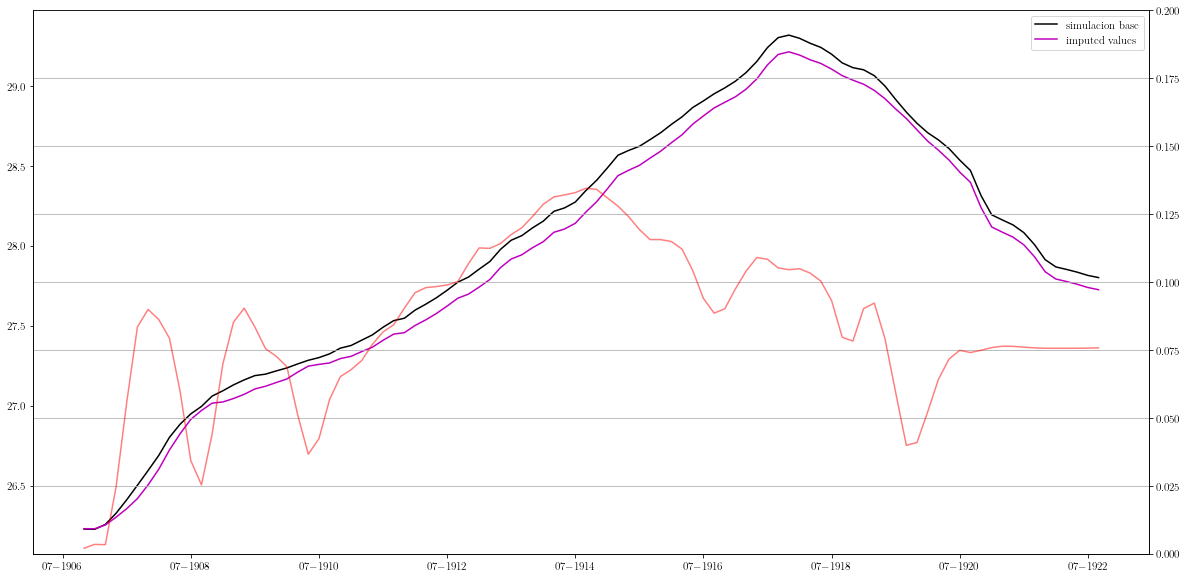

vanish_time: 0 days 15:50:00
N2AU203


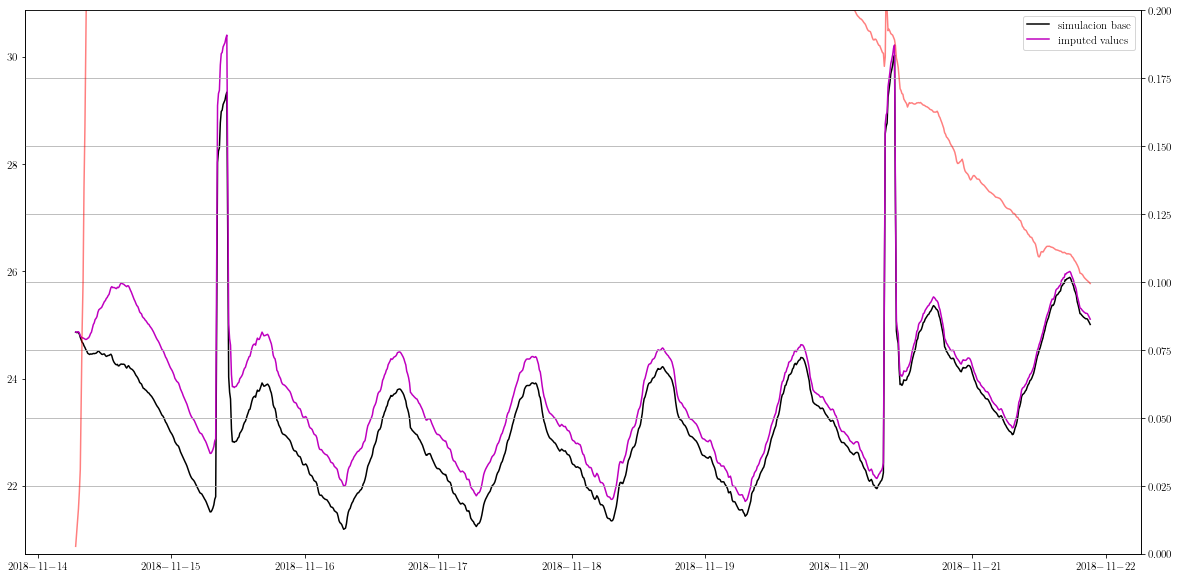

vanish_time: 7 days 14:20:00
N2AU203


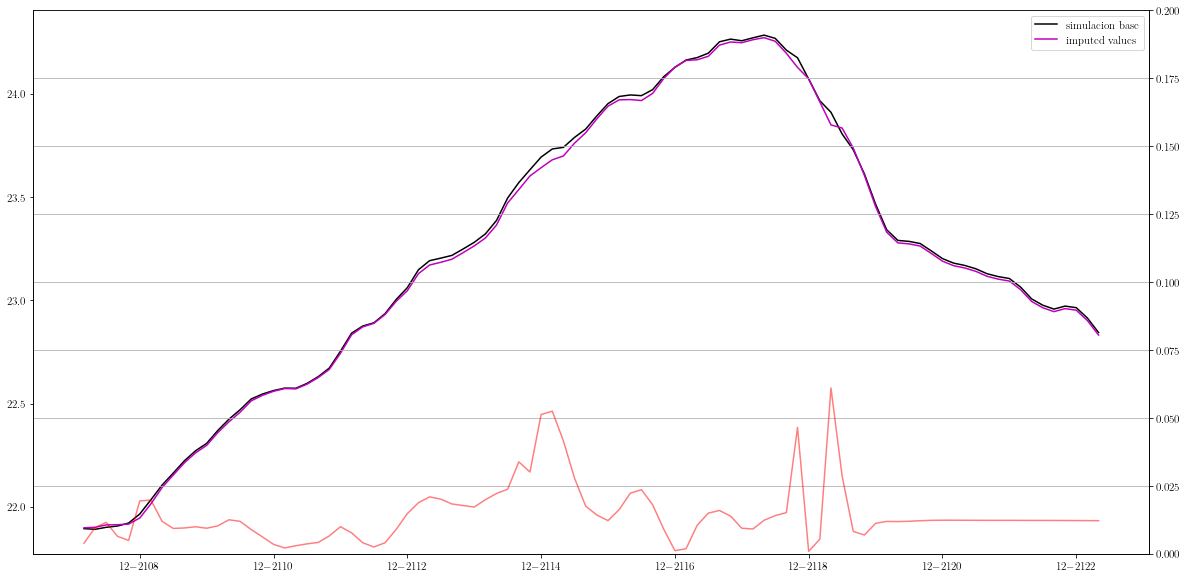

vanish_time: 0 days 15:10:00
N1AU404


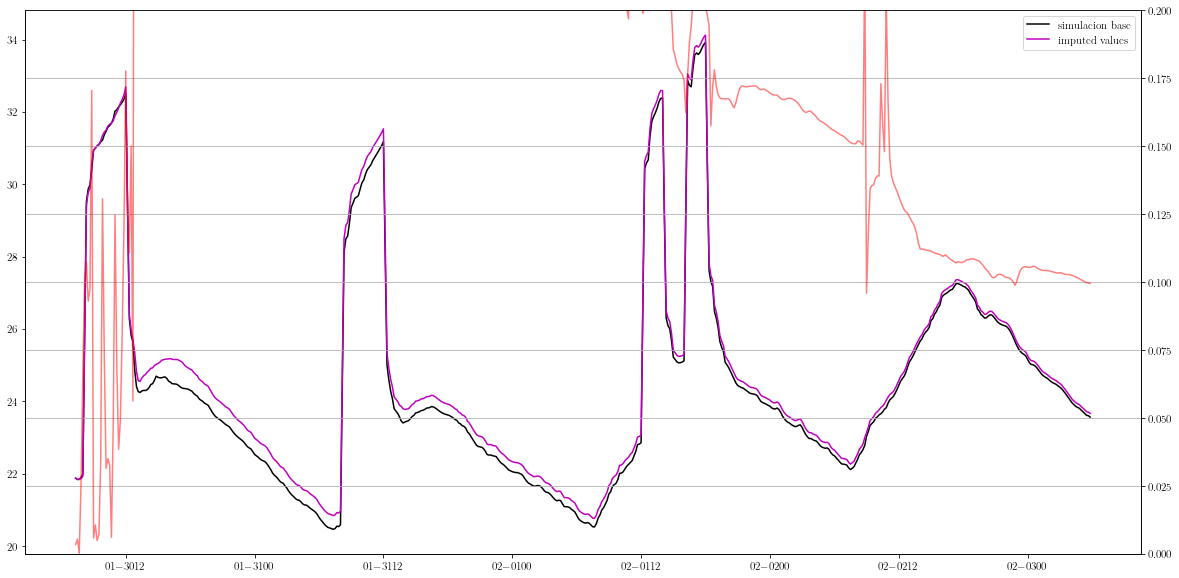

vanish_time: 3 days 22:30:00
N1AU404


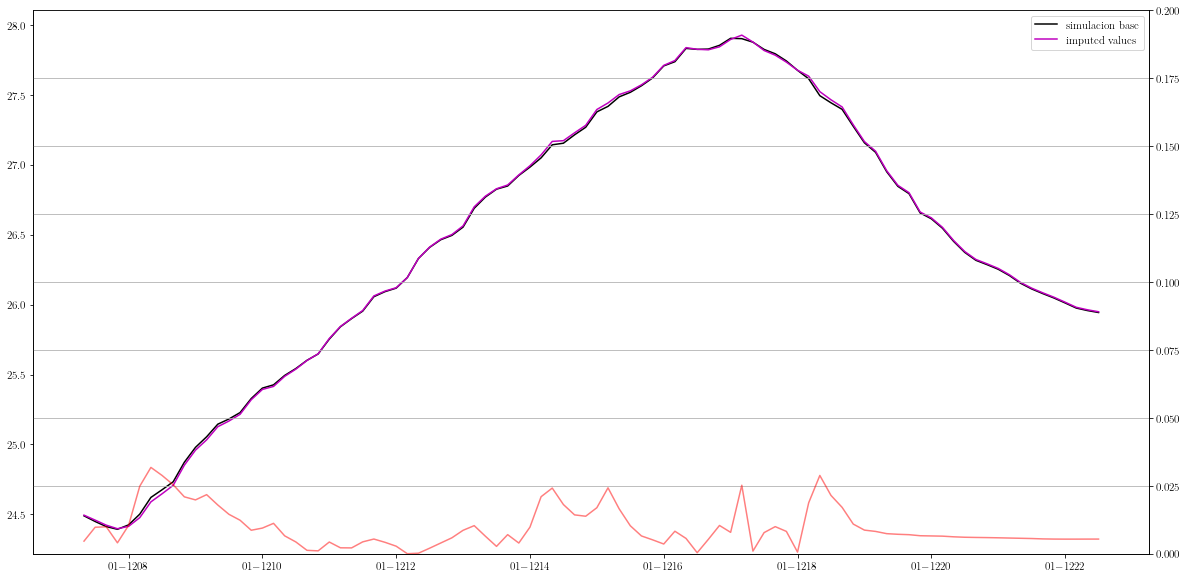

vanish_time: 0 days 15:10:00
N1AU404


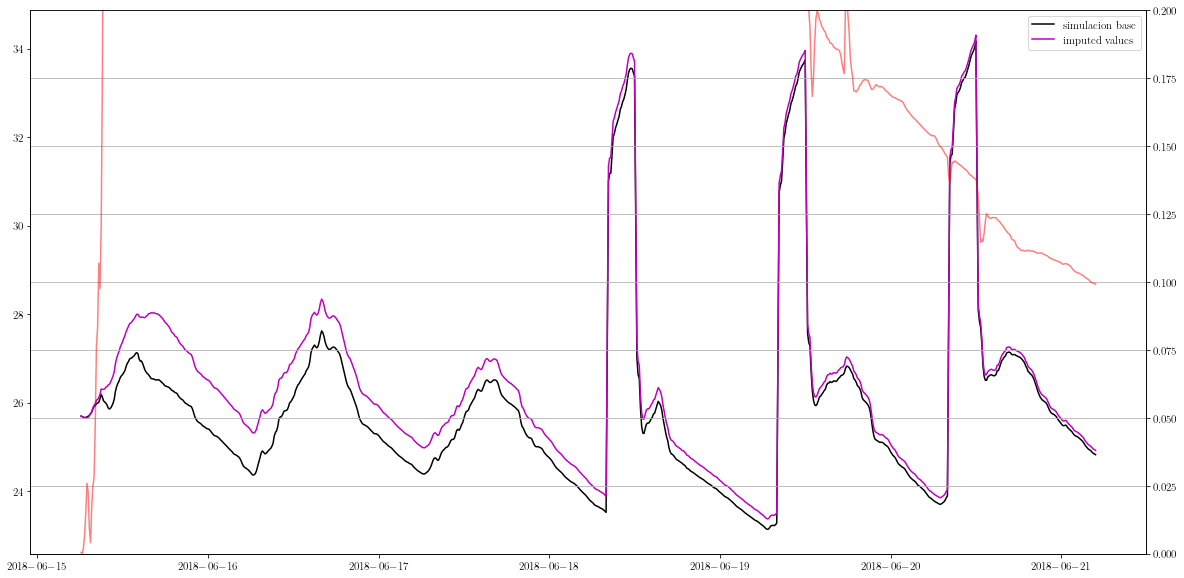

vanish_time: 5 days 22:40:00
N1AU404


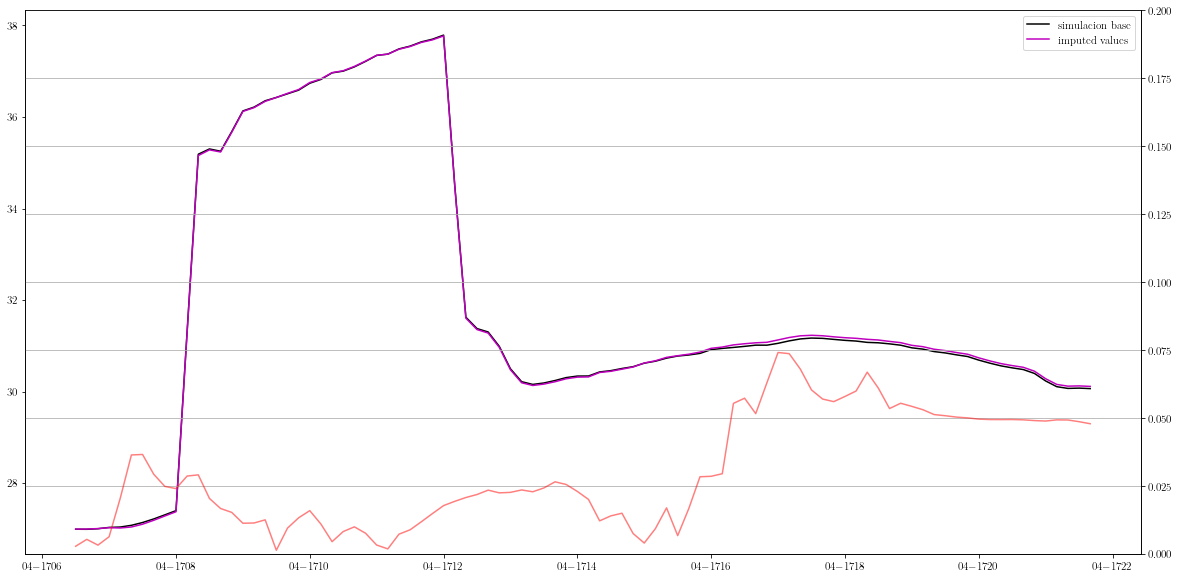

vanish_time: 0 days 15:10:00
N1AU404


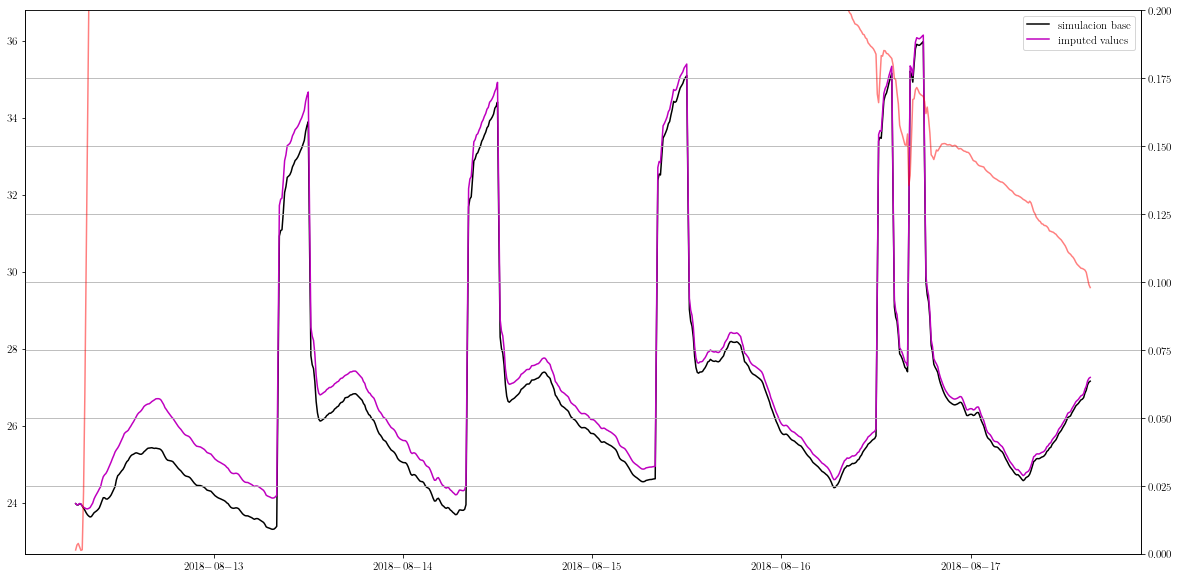

vanish_time: 5 days 08:40:00
N1AU404


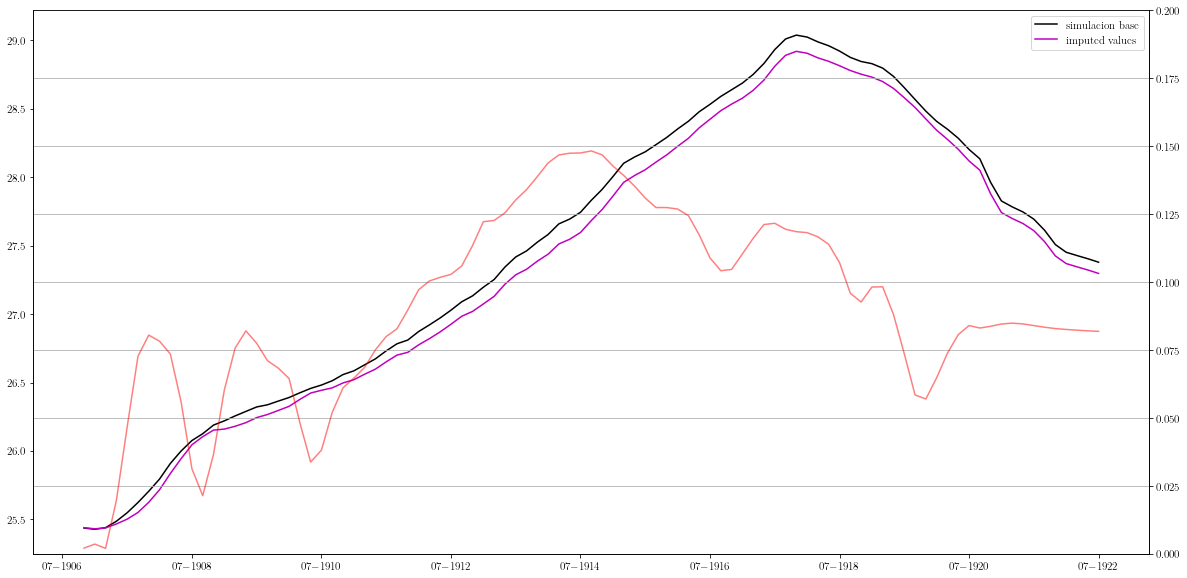

vanish_time: 0 days 15:40:00
N1AU404


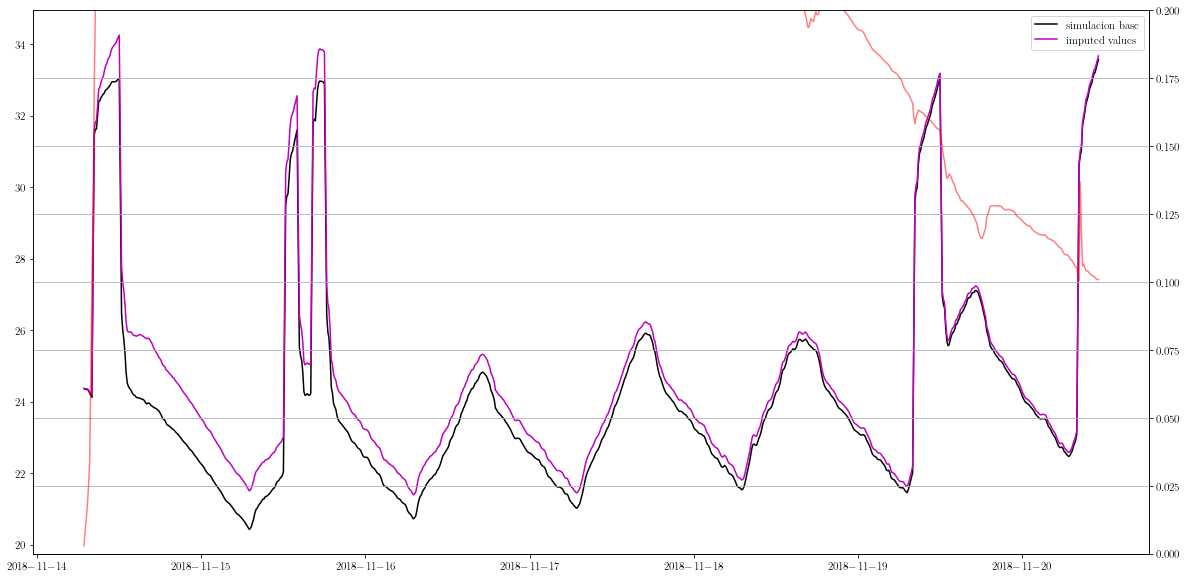

vanish_time: 6 days 04:20:00
N1AU404


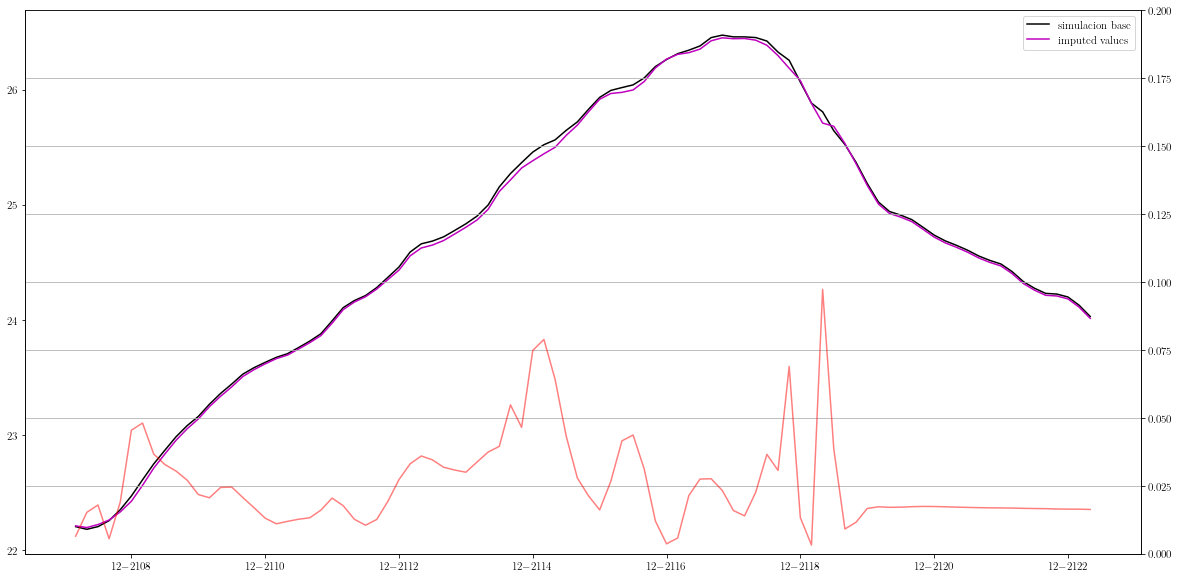

vanish_time: 0 days 15:10:00
PBCOORDINACION


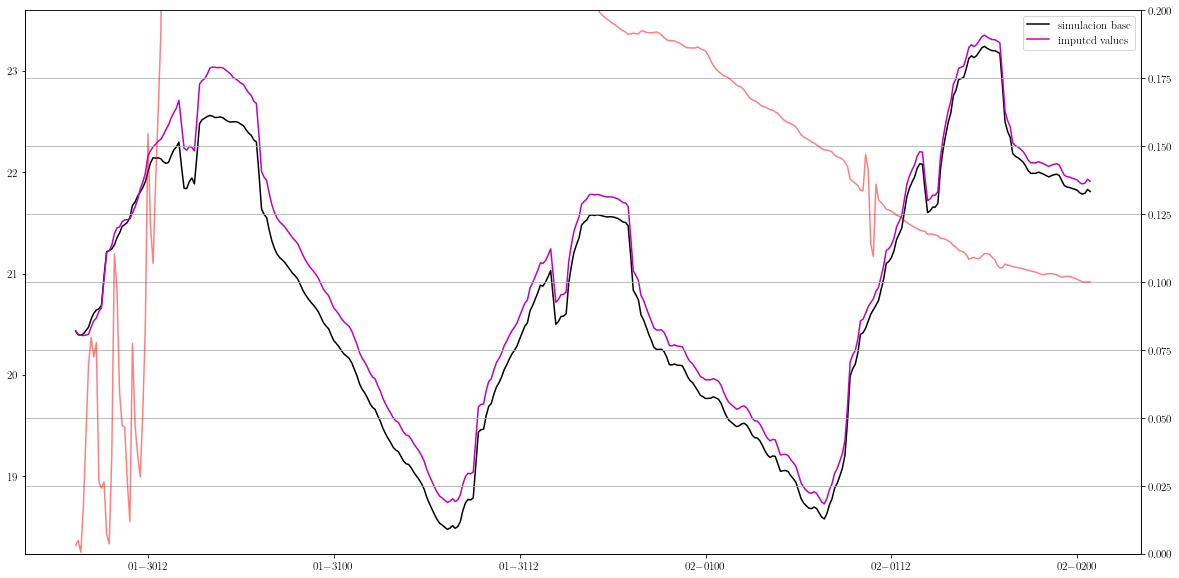

vanish_time: 2 days 17:30:00
PBCOORDINACION


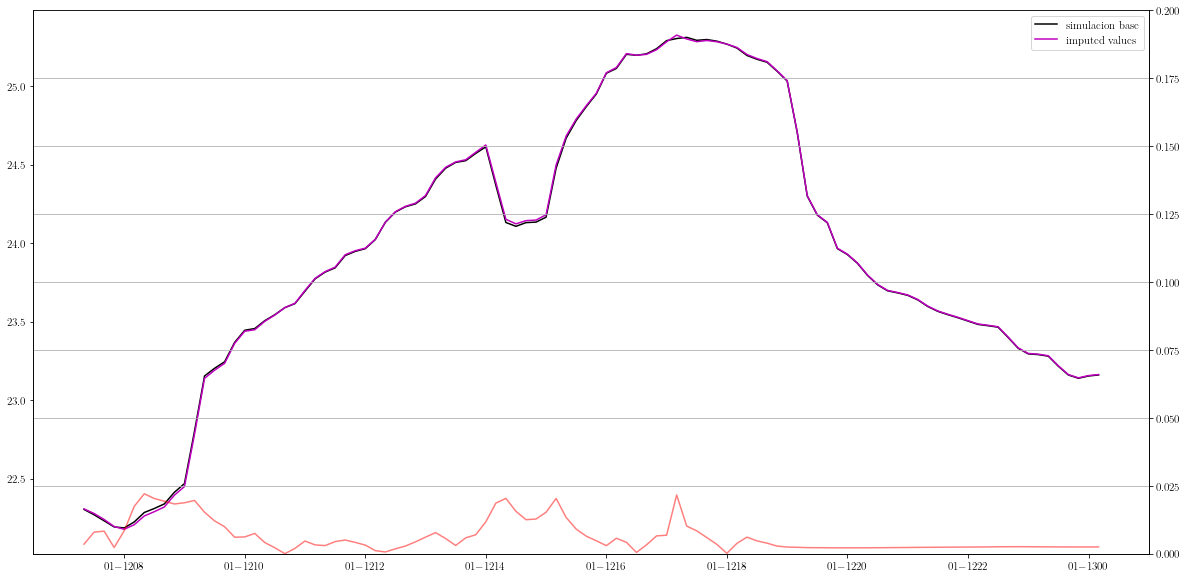

vanish_time: 0 days 16:50:00
PBCOORDINACION


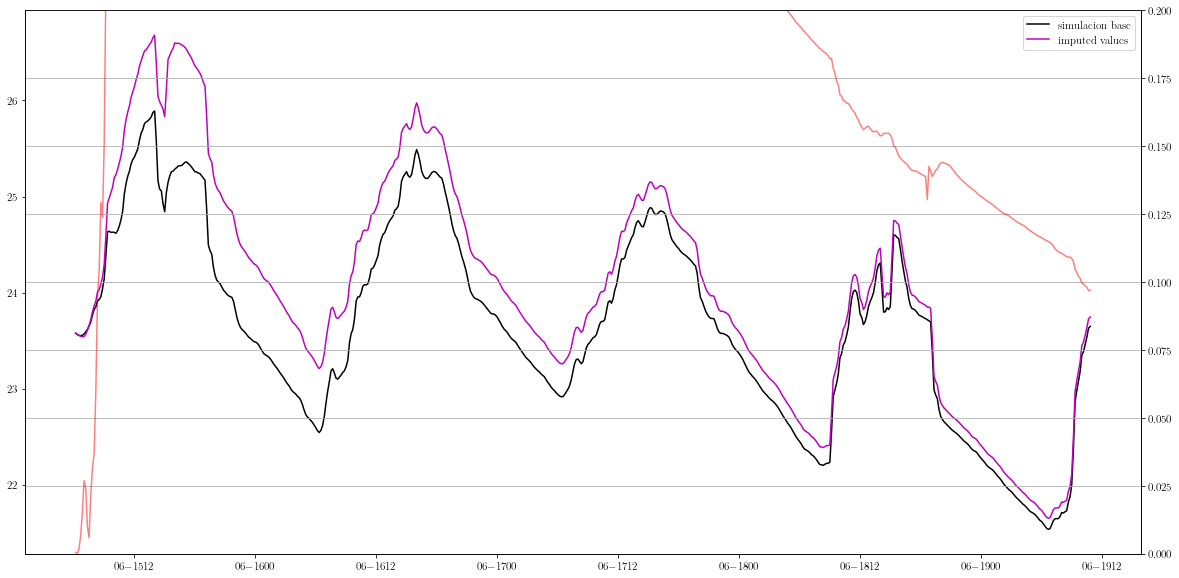

vanish_time: 4 days 04:40:00
PBCOORDINACION


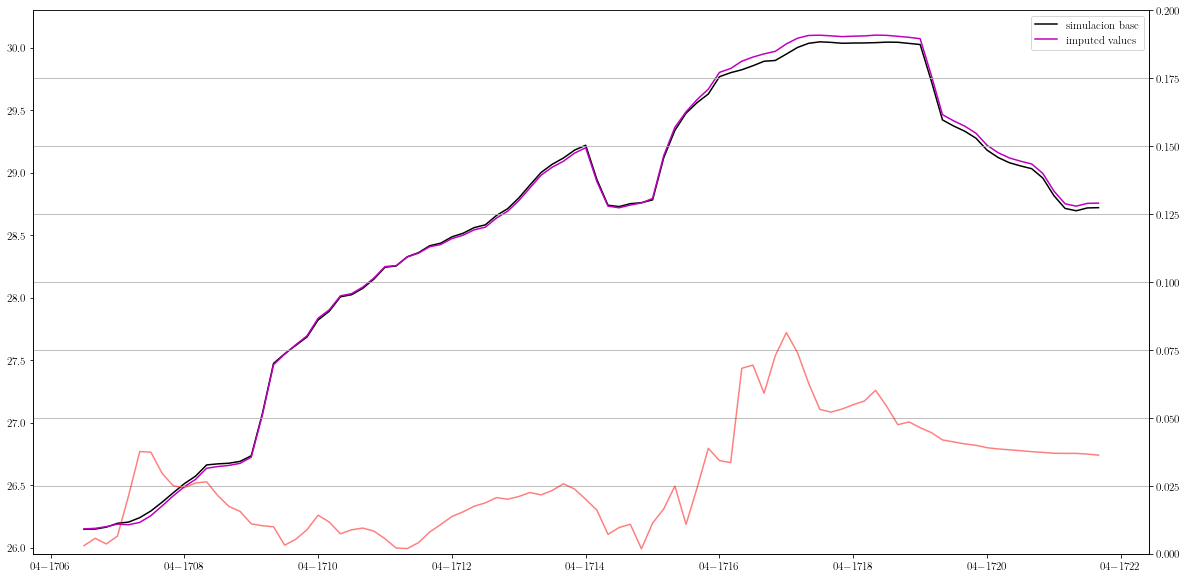

vanish_time: 0 days 15:10:00
PBCOORDINACION


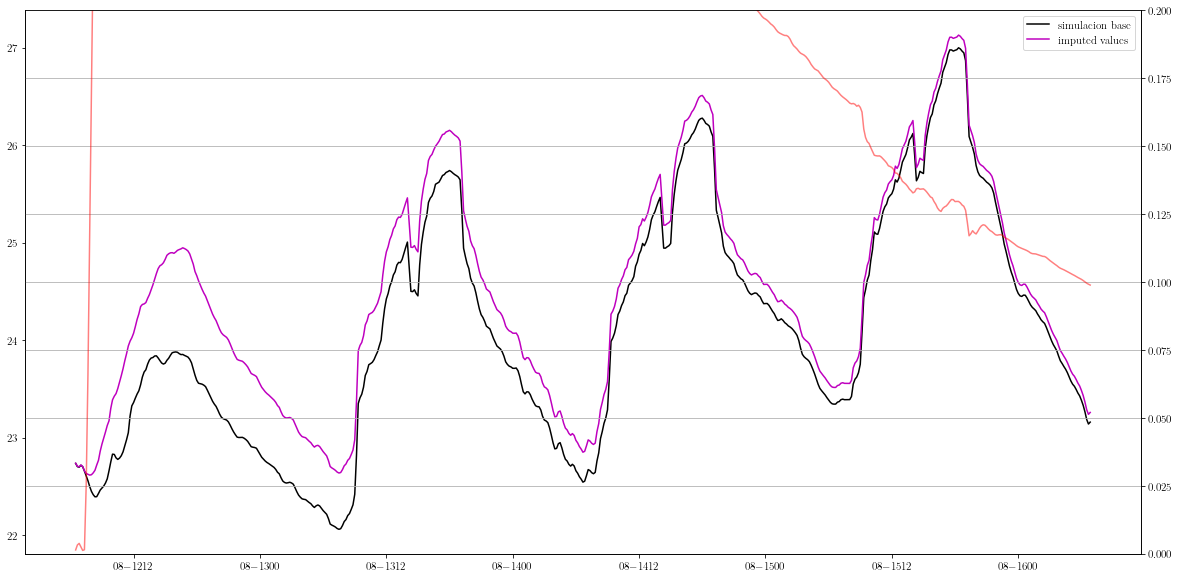

vanish_time: 4 days 00:20:00
PBCOORDINACION


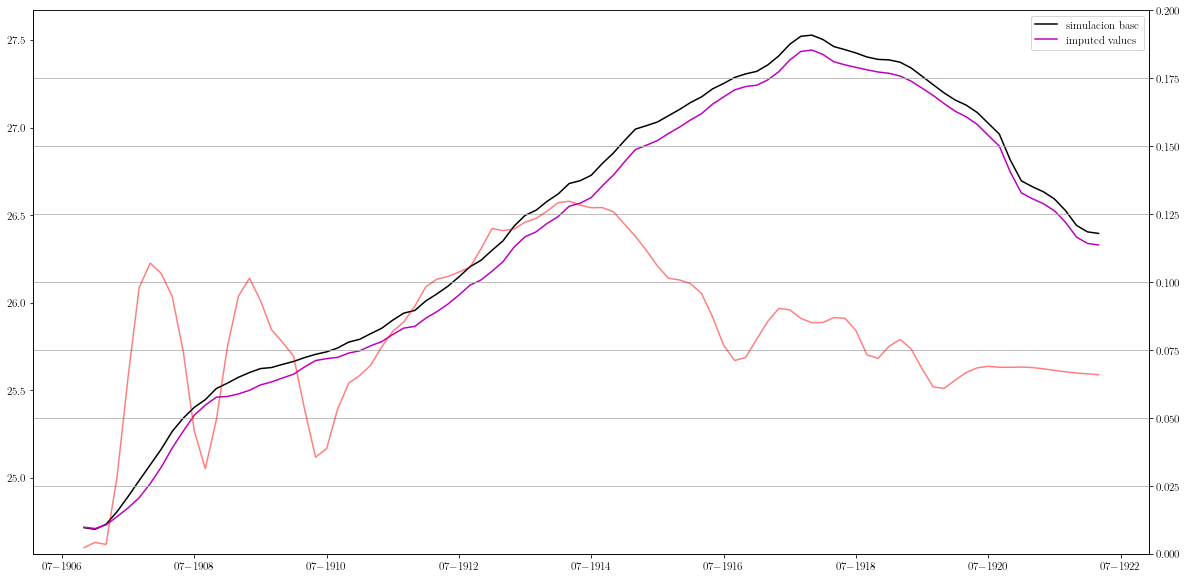

vanish_time: 0 days 15:20:00
PBCOORDINACION


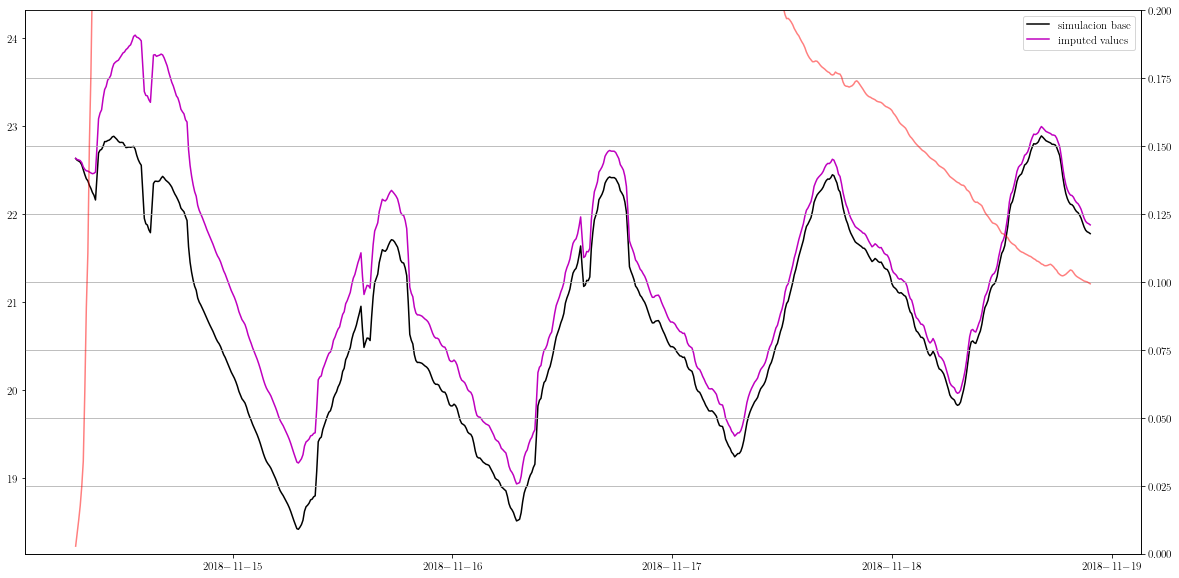

vanish_time: 4 days 14:50:00
PBCOORDINACION


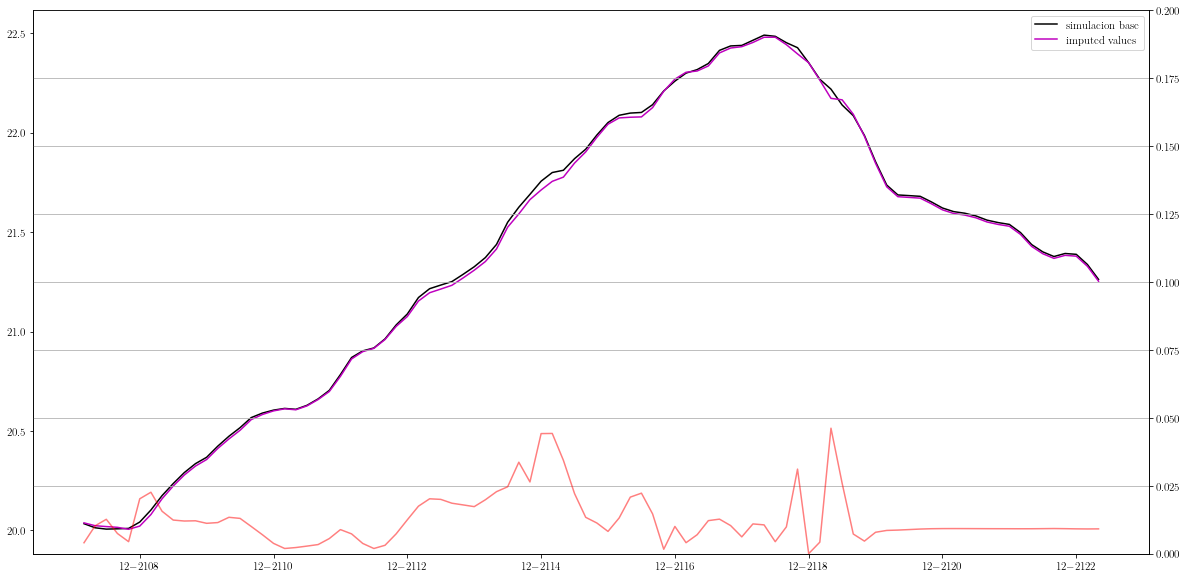

In [30]:
tolerance=.1
for tz in range (0,3,1):
    
    thermal_zone=low_thermal_zones[tz]
    plus='infiltration_ocupation'
    # 'N1AU404'
    # 'PBSCOM'
    path_metrics='02_simulation_metrics/'
    file_metrics='ann_imputation_metrics'+low_thermal_zones[tz]+plus+'.csv'
    tz=thermal_zone
    sim_imputed=sim_ann_imp3
    sim_base=sim_base3
    save=True
    for dia in range(len(dias)):
        vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
        sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
        print(thermal_zone)
        fig, ax=plt.subplots(figsize=(20,10))
        ax.plot(sim_base[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
        ax2=ax.twinx()
        ax.plot(sim_imputed[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='imputed values')
        ax2.plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',alpha=.5,label='error')
    #     ax2.plot(df_rolled[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='error_rolled')
        ax.legend()
        #ax2.legend()
        ax2.set_ylim(0,.2)
    #     ax.set_ylim(20,27)
        ax2.grid()
        plt.show()
        if save==True:
            if dia==0:
                first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
                cols=['Date_imputed','vanishing_time','Maximum_error','Time of maximum error','Time_for_maximum_error','Time from maximum to tolerated error']
                simulation_met=pd.DataFrame(first,columns=cols)
                simulation_met=simulation_met.set_index('Maximum_error')
                simulation_met.to_csv(path_metrics+file_metrics)
            else:
                first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
                actualizar_bitacora(first,cols,path_metrics,file_metrics)

In [17]:
for tz in range(len(high_thermal_zones)):
    ann_metrics=pd.read_csv(path_metrics+'ann_imputation_metrics'+high_thermal_zones[tz]+plus+'.csv')
    print(high_thermal_zones[tz])
    print(ann_metrics[['Date_imputed','vanishing_time','Maximum_error','Time_for_maximum_error']])


N2STR
          Date_imputed   vanishing_time  Maximum_error Time_for_maximum_error
0  2018-01-30 07:20:00  4 days 01:00:00       0.820002        0 days 09:40:00
1  2018-01-12 07:20:00  0 days 15:10:00       0.029251        0 days 01:00:00
2  2018-06-15 06:10:00  6 days 03:00:00       2.782942        0 days 09:10:00
3  2018-04-17 06:30:00  0 days 15:10:00       0.080634        0 days 10:30:00
4  2018-08-12 06:30:00  5 days 15:20:00       1.318088        0 days 10:40:00
5  2018-07-19 06:20:00  0 days 15:30:00       0.138552        0 days 08:00:00
6  2018-11-14 06:50:00  6 days 11:40:00       2.139711        0 days 08:30:00
7  2018-12-21 07:10:00  0 days 15:10:00       0.104865        0 days 11:10:00
N1AU401
          Date_imputed   vanishing_time  Maximum_error Time_for_maximum_error
0  2018-01-30 07:20:00  3 days 19:20:00       0.781453        0 days 09:50:00
1  2018-01-12 07:20:00  0 days 15:10:00       0.032775        0 days 01:00:00
2  2018-06-15 06:10:00  5 days 12:50:00       1.45

In [18]:
for tz in range(len(low_thermal_zones)):
    ann_metrics_pb=pd.read_csv(path_metrics+'ann_imputation_metrics'+low_thermal_zones[tz]+plus+'.csv')
    print(low_thermal_zones[tz])
    print(ann_metrics_pb[['Date_imputed','vanishing_time','Maximum_error','Time_for_maximum_error']])


N2AU203
          Date_imputed   vanishing_time  Maximum_error Time_for_maximum_error
0  2018-01-30 07:20:00  4 days 23:10:00       1.026050        2 days 03:00:00
1  2018-01-12 07:20:00  1 days 02:10:00       0.019315        0 days 01:00:00
2  2018-06-15 06:10:00  7 days 05:20:00       1.480417        0 days 10:30:00
3  2018-04-17 06:30:00  0 days 15:10:00       0.073602        0 days 10:30:00
4  2018-08-12 06:30:00  6 days 22:10:00       1.217850        0 days 10:30:00
5  2018-07-19 06:20:00  0 days 15:50:00       0.134577        0 days 07:50:00
6  2018-11-14 06:50:00  7 days 14:20:00       1.517715        0 days 09:10:00
7  2018-12-21 07:10:00  0 days 15:10:00       0.061079        0 days 11:10:00
N1AU404
          Date_imputed   vanishing_time  Maximum_error Time_for_maximum_error
0  2018-01-30 07:20:00  3 days 22:30:00       0.720258        0 days 09:50:00
1  2018-01-12 07:20:00  0 days 15:10:00       0.031861        0 days 01:00:00
2  2018-06-15 06:10:00  5 days 22:40:00       1.

In [19]:
#por qu'e hay un vanishing time menor, con un error mayor.
#por que n1au404 alcanza mayores temperaturas 
#hip'otesis: pbscom baja de temperatura mas dr'asticamente por tener mas contacto con el suelo
#n2str no tanto por estar mas en contacto con el sol

In [20]:
#en los peores d'ias, la imputaci'on suele estar sobreestimada. 

In [22]:
def setup(ax,incise,etiqueta_x=True):
    
    h_fmt=mdates.DateFormatter('%m-%d-%H')
    hours=mdates.HourLocator(interval=6)
    ax.set_xlim(fecha1,fecha2) 
    
    ax.set_ylim(0,1050)
    ax.xaxis.set_major_formatter(h_fmt)
    ax.xaxis.set_major_locator(hours)
    ax.set_ylabel(ylabel)
    if etiqueta_x:
        ax.set_xlabel('Time [mm-dd-HH]')
    ax.grid(alpha=.3)
    ax.text(right1, top1,incise,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes)

vanish_time: 7 days 14:20:00
vanish_time: 7 days 14:20:00
vanish_time: 6 days 11:40:00
vanish_time: 6 days 11:40:00


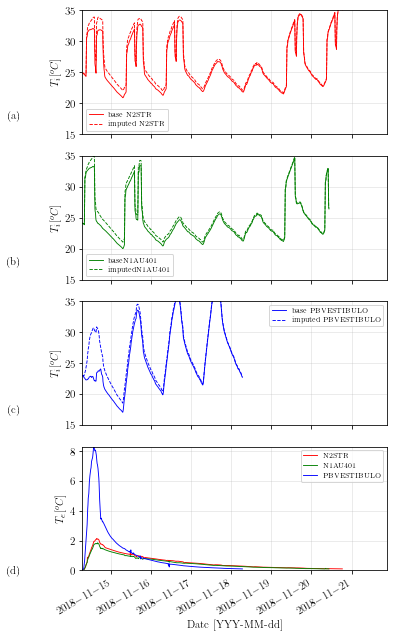

In [27]:
timedelta='0D'
left, width = -.9,.7
right1=left+width
bottom, height = -.15, .25
top1 = bottom + height

left, width = -.45, .2
right2=left+width
bottom, height = -1.5, .4
top2 = bottom + height

left, width = -.45, .2
right3=left+width
bottom, height = -2.8, .4
top3 = bottom + height


thermal_zone=low_thermal_zones[0]
vanish_time_ln2,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)


dia=6
supylim=35
infylim=15
size=(5.63, 9.0)
sim_imputed=sim_ann_imp3
sim_base=sim_base3
fig, ax = plt.subplots(4,1, sharex=True, sharey=False,figsize=size)
thermal_zone=high_thermal_zones[0]
vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)

ax[0].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',linewidth=.9,label='base '+thermal_zone)
ax[0].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time)],'r--',linewidth=.9,label='imputed '+thermal_zone)

ax[0].set_ylim(infylim,supylim)
ax[0].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time_pb)))

thermal_zone=high_thermal_zones[1]
vanish_time_n1,max_index_error_n1,max_time_n1,down_time_n1,max_error_n1,df_rolled_n1,df_inic_n1,df_diff_n1=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[1].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g-',linewidth=.9,label='base'+thermal_zone)
ax[1].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g--',linewidth=.9,label='imputed'+thermal_zone)

ax[1].set_ylim(infylim,supylim)
ax[1].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time_pb)))
# ax2.plot(df_inic_n1[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g-',label='error_n1')

thermal_zone=high_thermal_zones[2]
vanish_time_pb,max_index_error_pb,max_time_pb,down_time_pb,max_error_pb,df_rolled_pb,df_inic_pb,df_diff_pb=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[2].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b-',linewidth=.9,label='base '+thermal_zone)

ax[2].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b--',linewidth=.9,label='imputed '+thermal_zone)
ax[2].set_ylim(infylim,supylim)
ax[2].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time_pb)))


ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)
ax[2].legend(fontsize=7)
fig.autofmt_xdate()

thermal_zone=high_thermal_zones[0]
#vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
# sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[3].plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',linewidth=.9,label=thermal_zone)

thermal_zone=high_thermal_zones[1]
ax[3].plot(df_inic_n1[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g-',linewidth=.9,label=thermal_zone)
 
thermal_zone=high_thermal_zones[2]
ax[3].plot(df_inic_pb[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b-',linewidth=.9,label=thermal_zone)

ax[0].text(right1, top1,'(a)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[0].transAxes)
ax[1].text(right1, top1,'(b)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)
ax[2].text(right1, top2,'(c)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)
ax[3].text(right1, top3,'(d)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)



ax[3].legend(fontsize=7)
ax[3].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time_ln2)))
ax[3].set_ylim(0,8.3)
ax[3].grid(alpha=.3)
ax[3].set_ylabel('$T_e$[$^oC$]')
ax[3].set_xlabel('Date [YYY-MM-dd]')

ax[0].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[1].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[2].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)
ax[2].grid(alpha=.3)
ax[3].grid(alpha=.3)

fig.tight_layout()
# plt.savefig('../../../Tesis_repo/figures/high_tz.pdf')


vanish_time: 7 days 14:20:00
vanish_time: 7 days 14:20:00
vanish_time: 7 days 14:20:00


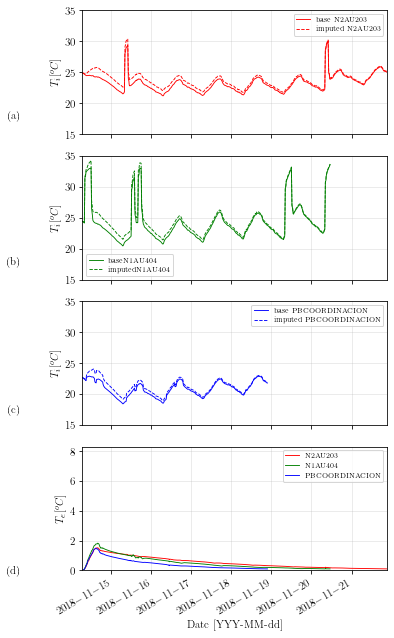

In [29]:
thermal_zones=['N2AU202','N1AU401','PBSJUNTAS']

supylim=35
infylim=15
fig, ax = plt.subplots(4,1, sharex=True, sharey=False,figsize=size)
thermal_zone=low_thermal_zones[0]
vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[0].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',linewidth=.9,label='base '+thermal_zone)
ax[0].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time)],'r--',linewidth=.9,label='imputed '+thermal_zone)

ax[0].set_ylim(infylim,supylim)
ax[0].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time)))

thermal_zone=low_thermal_zones[1]
vanish_time_n1,max_index_error_n1,max_time_n1,down_time_n1,max_error_n1,df_rolled_n1,df_inic_n1,df_diff_n1=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[1].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g-',linewidth=.9,label='base'+thermal_zone)
ax[1].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g--',linewidth=.9,label='imputed'+thermal_zone)

ax[1].set_ylim(infylim,supylim)
ax[1].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time)))

thermal_zone=low_thermal_zones[2]
vanish_time_pb,max_index_error_pb,max_time_pb,down_time_pb,max_error_pb,df_rolled_pb,df_inic_pb,df_diff_pb=simulation_metrics(
sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[2].plot(sim_base[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b-',linewidth=.9,label='base '+thermal_zone)

ax[2].plot(sim_imputed[thermal_zone].loc[parse(dias[dia])-pd.Timedelta(timedelta):parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b--',linewidth=.9,label='imputed '+thermal_zone)
ax[2].set_ylim(infylim,supylim)
ax[2].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time)))


ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)
ax[2].legend(fontsize=7)
fig.autofmt_xdate()

thermal_zone=low_thermal_zones[0]
#vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(
# sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
ax[3].plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',linewidth=.9,label=thermal_zone)

thermal_zone=low_thermal_zones[1]
ax[3].plot(df_inic_n1[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time_n1)],'g-',linewidth=.9,label=thermal_zone)
 
thermal_zone=low_thermal_zones[2]
ax[3].plot(df_inic_pb[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time_pb)],'b-',linewidth=.9,label=thermal_zone)


ax[3].legend(fontsize=7)
ax[3].set_xlim(pd.Timestamp(dias[dia]),pd.Timestamp(parse(dias[dia])+pd.Timedelta(vanish_time)))
ax[3].set_ylim(0,8.3)
ax[3].grid(alpha=.3)
ax[3].set_ylabel('$T_e$[$^oC$]')
ax[3].set_xlabel('Date [YYY-MM-dd]')


ax[0].text(right1, top1,'(a)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[0].transAxes)
ax[1].text(right1, top1,'(b)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)
ax[2].text(right1, top2,'(c)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)
ax[3].text(right1, top3,'(d)',
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax[1].transAxes)


ax[0].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[1].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[2].set_ylabel('$T_i$[$^oC$]',fontsize=11)
ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)
ax[2].grid(alpha=.3)
ax[3].grid(alpha=.3)

fig.tight_layout()
# plt.savefig('../../../Tesis_repo/figures/low_tz.pdf')

